In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install required packages
!pip install torch torchvision torchaudio librosa tqdm matplotlib scikit-learn soundfile --quiet

import os
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import IPython.display as ipd

print("✅ Libraries ready!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [3]:
# Install only necessary packages without dependencies
!pip install librosa soundfile --quiet

import os
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import IPython.display as ipd

print("✅ Libraries ready!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries ready!
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB


In [5]:
# === Replace with your actual dataset name ===
dataset_name = "datasetrsunet"  # CHANGE THIS

clean_dir = f"/kaggle/input/{dataset_name}/clean_wav/clean_wav"
noise_dir = f"/kaggle/input/{dataset_name}/noise_wav/noise_wav"

# Verify dataset exists
if not os.path.exists(clean_dir):
    print(f"❌ Clean directory not found: {clean_dir}")
    print("Available datasets in /kaggle/input/:")
    print(os.listdir("/kaggle/input/"))
else:
    print(f"✅ Clean files found: {len(os.listdir(clean_dir))}")

if not os.path.exists(noise_dir):
    print(f"❌ Noise directory not found: {noise_dir}")
else:
    print(f"✅ Noise files found: {len(os.listdir(noise_dir))}")

# Output directories
mix_dir = "/kaggle/working/mixed_balanced_wav"
output_root = "/kaggle/working/dataset"

# Create directories
os.makedirs(mix_dir, exist_ok=True)
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "noisy_mag"), exist_ok=True)
os.makedirs(os.path.join(output_root, "clean_mag"), exist_ok=True)
os.makedirs(os.path.join(output_root, "phase"), exist_ok=True)

print("✅ All directories created!")

✅ Clean files found: 10
✅ Noise files found: 22
✅ All directories created!


In [6]:
def prepare_balanced_mixes(clean_dir, noise_dir, mix_dir, mix_ratios=[0.3, 0.5, 0.7], target_sr=16000):
    """Create balanced noisy mixtures"""
    import warnings
    warnings.filterwarnings('ignore')
    
    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".wav")])
    noise_files = sorted([f for f in os.listdir(noise_dir) if f.endswith(".wav")])
    
    print(f"Processing {len(clean_files)} clean files and {len(noise_files)} noise files")
    
    for clean_file in tqdm(clean_files, desc="Mixing audio"):
        clean_path = os.path.join(clean_dir, clean_file)
        
        try:
            clean_audio, _ = librosa.load(clean_path, sr=target_sr)
        except Exception as e:
            print(f"Error loading {clean_path}: {e}")
            continue
            
        for noise_file in noise_files:
            noise_path = os.path.join(noise_dir, noise_file)
            
            try:
                noise_audio, _ = librosa.load(noise_path, sr=target_sr)
            except Exception as e:
                print(f"Error loading {noise_path}: {e}")
                continue
            
            # Align lengths
            min_len = min(len(clean_audio), len(noise_audio))
            if min_len == 0:
                continue
                
            clean_audio_trim = clean_audio[:min_len]
            noise_audio_trim = noise_audio[:min_len]
            
            # Normalize
            clean_audio_trim = clean_audio_trim / (np.max(np.abs(clean_audio_trim)) + 1e-8)
            noise_audio_trim = noise_audio_trim / (np.max(np.abs(noise_audio_trim)) + 1e-8)
            
            # Mix for each ratio
            for r in mix_ratios:
                noisy = (1 - r) * clean_audio_trim + r * noise_audio_trim
                noisy = noisy / (np.max(np.abs(noisy)) + 1e-8)
                
                mix_name = f"{clean_file[:-4]}_{noise_file[:-4]}_{int(r*100)}.wav"
                mix_path = os.path.join(mix_dir, mix_name)
                sf.write(mix_path, noisy, target_sr)
    
    print(f"✅ Mixed files created: {len(os.listdir(mix_dir))}")

# Run mixing
prepare_balanced_mixes(clean_dir, noise_dir, mix_dir)

Processing 10 clean files and 22 noise files


Mixing audio: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

✅ Mixed files created: 660


In [8]:
def prepare_stft_dataset(clean_dir, mixed_dir, output_root, sr=16000, n_fft=1024, hop_length=256):
    """Prepare STFT dataset"""
    mixed_files = [f for f in os.listdir(mixed_dir) if f.endswith(".wav")]
    print(f"Processing {len(mixed_files)} mixed files")
    
    successful = 0
    for f in tqdm(mixed_files, desc="Creating STFT features"):
        mixed_path = os.path.join(mixed_dir, f)
        
        # Get corresponding clean file
        base_clean_name = f.split("_")[0]
        clean_path = os.path.join(clean_dir, base_clean_name + ".wav")
        
        if not os.path.exists(clean_path):
            continue
            
        try:
            # Load audio
            noisy, _ = librosa.load(mixed_path, sr=sr)
            clean, _ = librosa.load(clean_path, sr=sr)
            
            # Compute STFT
            noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)
            clean_stft = librosa.stft(clean, n_fft=n_fft, hop_length=hop_length)
            
            # Extract components
            noisy_mag = np.abs(noisy_stft)
            clean_mag = np.abs(clean_stft)
            phase = np.angle(noisy_stft)
            
            # Save
            base_name = f.replace(".wav", "")
            np.save(os.path.join(output_root, "noisy_mag", f"{base_name}_noisy_mag.npy"), noisy_mag)
            np.save(os.path.join(output_root, "clean_mag", f"{base_name}_clean_mag.npy"), clean_mag)
            np.save(os.path.join(output_root, "phase", f"{base_name}_phase.npy"), phase)
            
            successful += 1
            
        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue
    
    print(f"✅ Successfully processed {successful} files")

prepare_stft_dataset(clean_dir, mix_dir, output_root)

Processing 660 mixed files


Creating STFT features: 100%|██████████| 660/660 [00:09<00:00, 66.14it/s]

✅ Successfully processed 660 files


In [9]:
class SpeechDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, max_frames=256):
        self.noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith(".npy")])
        self.clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".npy")])
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.max_frames = max_frames

    def pad_or_crop(self, x):
        freq, time = x.shape
        if time < self.max_frames:
            pad = np.zeros((freq, self.max_frames - time))
            x = np.concatenate([x, pad], axis=1)
        else:
            x = x[:, :self.max_frames]
        return x

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        noisy = np.load(os.path.join(self.noisy_dir, self.noisy_files[idx]))
        clean = np.load(os.path.join(self.clean_dir, self.clean_files[idx]))
        noisy = self.pad_or_crop(noisy)
        clean = self.pad_or_crop(clean)
        return torch.tensor(noisy).unsqueeze(0).float(), torch.tensor(clean).unsqueeze(0).float()

# Create dataset
noisy_dir = "/kaggle/working/dataset/noisy_mag"
clean_dir_stft = "/kaggle/working/dataset/clean_mag"

dataset = SpeechDataset(noisy_dir, clean_dir_stft, max_frames=256)

# Split dataset
n = len(dataset)
train_len = int(0.8 * n)
val_len = int(0.1 * n)
test_len = n - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8)
test_dl = DataLoader(test_ds, batch_size=8)

print(f"✅ Dataset: {train_len} train, {val_len} val, {test_len} test")

✅ Dataset: 528 train, 66 val, 66 test


In [13]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + residual)

class RSUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ResidualBlock(1, 32)
        self.enc2 = ResidualBlock(32, 64)
        self.enc3 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualBlock(128, 256)

        # Decoder
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = ResidualBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ResidualBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ResidualBlock(64, 32)

        # Output
        self.out_conv = nn.Conv2d(32, 1, 1)

    def crop_or_pad(self, src, target):
        """Make src same size (H, W) as target"""
        diffY = target.size(2) - src.size(2)
        diffX = target.size(3) - src.size(3)
        src = F.pad(src, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])
        return src

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = self.crop_or_pad(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = self.crop_or_pad(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = self.crop_or_pad(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return out

print("✅ Model defined successfully!")

✅ Model defined successfully!


In [14]:
# Let's check the data shapes before training
noisy_batch, clean_batch = next(iter(train_dl))
print(f"Noisy batch shape: {noisy_batch.shape}")
print(f"Clean batch shape: {clean_batch.shape}")

# Test the model with a sample batch
model = RSUNet()
with torch.no_grad():
    sample_output = model(noisy_batch)
    print(f"Model output shape: {sample_output.shape}")

print("✅ Data shapes are compatible!")

Noisy batch shape: torch.Size([8, 1, 513, 256])
Clean batch shape: torch.Size([8, 1, 513, 256])
Model output shape: torch.Size([8, 1, 513, 256])
✅ Data shapes are compatible!


In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Model, Loss, Optimizer
model = RSUNet().to(device)
criterion = nn.L1Loss()  # Using L1 loss as in original code
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print("✅ Training setup complete!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

🚀 Using device: Tesla P100-PCIE-16GB
✅ Training setup complete!
Model parameters: 2,014,593


In [16]:
# Training configuration
num_epochs = 30
patience = 5
best_val_loss = float('inf')
no_improve = 0

# Lists to track metrics
train_losses = []
val_losses = []

print("🚀 Starting training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for noisy, clean in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        noisy, clean = noisy.to(device), clean.to(device)
        
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for noisy, clean in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item()
            val_batches += 1
    
    # Calculate averages
    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Val Loss: {avg_val_loss:.6f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, "/kaggle/working/best_rsunet.pth")
        print("  💾 Best model saved!")
    else:
        no_improve += 1
    
    # Early stopping
    if no_improve >= patience:
        print(f"🛑 Early stopping after {epoch+1} epochs")
        break
    
    print("-" * 50)

print("✅ Training completed!")

🚀 Starting training...


Epoch 1/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 15.95it/s]


Epoch 1/30:
  Train Loss: 0.029597
  Val Loss: 0.020204
  LR: 1.00e-03
  💾 Best model saved!
--------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.14it/s]


Epoch 2/30:
  Train Loss: 0.016965
  Val Loss: 0.020561
  LR: 1.00e-03
--------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.36it/s]


Epoch 3/30:
  Train Loss: 0.014642
  Val Loss: 0.017873
  LR: 1.00e-03
  💾 Best model saved!
--------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.19it/s]


Epoch 4/30:
  Train Loss: 0.013756
  Val Loss: 0.015729
  LR: 1.00e-03
  💾 Best model saved!
--------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.27it/s]


Epoch 5/30:
  Train Loss: 0.011315
  Val Loss: 0.014607
  LR: 1.00e-03
  💾 Best model saved!
--------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.32it/s]


Epoch 6/30:
  Train Loss: 0.010572
  Val Loss: 0.011263
  LR: 1.00e-03
  💾 Best model saved!
--------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.28it/s]


Epoch 7/30:
  Train Loss: 0.010182
  Val Loss: 0.011428
  LR: 1.00e-03
--------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.35it/s]


Epoch 8/30:
  Train Loss: 0.009354
  Val Loss: 0.012613
  LR: 1.00e-03
--------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s]


Epoch 9/30:
  Train Loss: 0.008953
  Val Loss: 0.017851
  LR: 5.00e-04
--------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.32it/s]


Epoch 10/30:
  Train Loss: 0.008315
  Val Loss: 0.009986
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.44it/s]


Epoch 11/30:
  Train Loss: 0.007771
  Val Loss: 0.007918
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.40it/s]


Epoch 12/30:
  Train Loss: 0.007287
  Val Loss: 0.009177
  LR: 5.00e-04
--------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.34it/s]


Epoch 13/30:
  Train Loss: 0.007422
  Val Loss: 0.009302
  LR: 5.00e-04
--------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.30it/s]


Epoch 14/30:
  Train Loss: 0.007052
  Val Loss: 0.007853
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.33it/s]


Epoch 15/30:
  Train Loss: 0.006799
  Val Loss: 0.007790
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.45it/s]


Epoch 16/30:
  Train Loss: 0.006724
  Val Loss: 0.008723
  LR: 5.00e-04
--------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.15it/s]


Epoch 17/30:
  Train Loss: 0.006664
  Val Loss: 0.008301
  LR: 5.00e-04
--------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.40it/s]


Epoch 18/30:
  Train Loss: 0.006602
  Val Loss: 0.007717
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.31it/s]


Epoch 19/30:
  Train Loss: 0.006999
  Val Loss: 0.008212
  LR: 5.00e-04
--------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.29it/s]


Epoch 20/30:
  Train Loss: 0.006239
  Val Loss: 0.007683
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.28it/s]


Epoch 21/30:
  Train Loss: 0.006126
  Val Loss: 0.006520
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.29it/s]


Epoch 22/30:
  Train Loss: 0.006140
  Val Loss: 0.007310
  LR: 5.00e-04
--------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.34it/s]


Epoch 23/30:
  Train Loss: 0.005758
  Val Loss: 0.006281
  LR: 5.00e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.37it/s]


Epoch 24/30:
  Train Loss: 0.005735
  Val Loss: 0.007253
  LR: 5.00e-04
--------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.28it/s]


Epoch 25/30:
  Train Loss: 0.005641
  Val Loss: 0.006348
  LR: 5.00e-04
--------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.40it/s]


Epoch 26/30:
  Train Loss: 0.005551
  Val Loss: 0.006320
  LR: 2.50e-04
--------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


Epoch 27/30:
  Train Loss: 0.005210
  Val Loss: 0.006514
  LR: 2.50e-04
--------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.41it/s]


Epoch 28/30:
  Train Loss: 0.005063
  Val Loss: 0.006132
  LR: 2.50e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.36it/s]


Epoch 29/30:
  Train Loss: 0.005066
  Val Loss: 0.005855
  LR: 2.50e-04
  💾 Best model saved!
--------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.19it/s]

Epoch 30/30:
  Train Loss: 0.004901
  Val Loss: 0.006243
  LR: 2.50e-04
--------------------------------------------------
✅ Training completed!


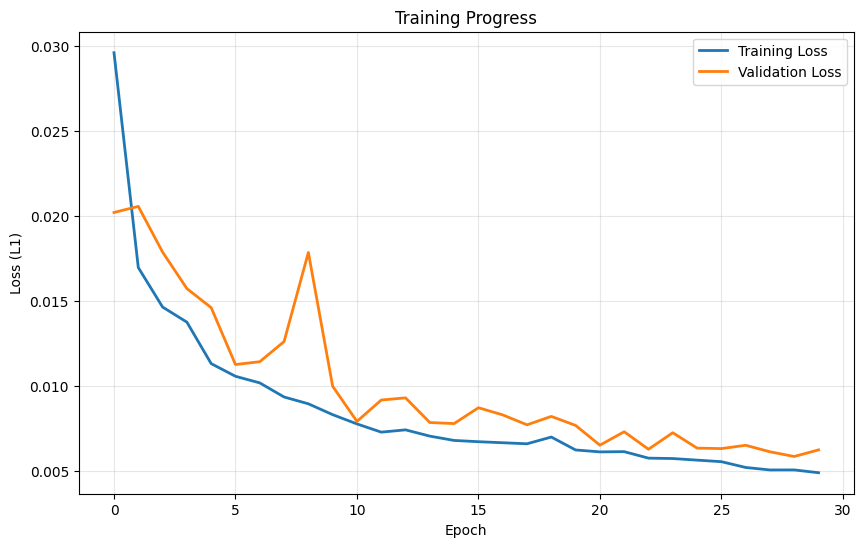

Best validation loss: 0.005855


In [20]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/kaggle/working/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.6f}")

In [18]:
# Load best model
checkpoint = torch.load("/kaggle/working/best_rsunet.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Best model loaded!")

# Test on a few samples
test_loss = 0.0
test_samples = 0

with torch.no_grad():
    for i, (noisy, clean) in enumerate(test_dl):
        if i >= 3:  # Just test first 3 batches
            break
            
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        loss = criterion(output, clean)
        test_loss += loss.item()
        test_samples += 1
        
        print(f"Test sample {i+1}: Loss = {loss.item():.6f}")

avg_test_loss = test_loss / test_samples if test_samples > 0 else 0
print(f"\n🎯 Average test loss (first 3 batches): {avg_test_loss:.6f}")

✅ Best model loaded!
Test sample 1: Loss = 0.004055
Test sample 2: Loss = 0.004512
Test sample 3: Loss = 0.004584

🎯 Average test loss (first 3 batches): 0.004384


In [19]:
def reconstruct_audio(model, noisy_mag, phase, hop_length=256):
    """Reconstruct audio from magnitude spectrogram"""
    model.eval()
    with torch.no_grad():
        # Denoise the magnitude
        noisy_tensor = torch.tensor(noisy_mag).unsqueeze(0).unsqueeze(0).float().to(device)
        denoised_mag = model(noisy_tensor).squeeze().cpu().numpy()
    
    # Reconstruct complex STFT
    denoised_stft = denoised_mag * np.exp(1j * phase)
    
    # Convert back to audio
    denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
    
    return denoised_audio

# Test on a sample from test set
test_noisy_dir = "/kaggle/working/dataset/noisy_mag"
test_phase_dir = "/kaggle/working/dataset/phase"

# Get a test sample
test_files = os.listdir(test_noisy_dir)
sample_file = test_files[0]  # First test sample

# Load the test data
noisy_mag = np.load(os.path.join(test_noisy_dir, sample_file))
phase = np.load(os.path.join(test_phase_dir, sample_file.replace("noisy_mag", "phase")))

# Reconstruct audio
denoised_audio = reconstruct_audio(model, noisy_mag, phase)

# Also get the original mixed audio for comparison
mixed_files = os.listdir(mix_dir)
original_mixed_file = [f for f in mixed_files if f.replace(".wav", "_noisy_mag.npy") == sample_file][0]
original_mixed_audio, sr = librosa.load(os.path.join(mix_dir, original_mixed_file), sr=16000)

# Get clean audio for comparison
clean_file = sample_file.split("_")[0] + ".wav"
clean_audio, _ = librosa.load(os.path.join(clean_dir, clean_file), sr=16000)

print("✅ Audio reconstruction completed!")

✅ Audio reconstruction completed!


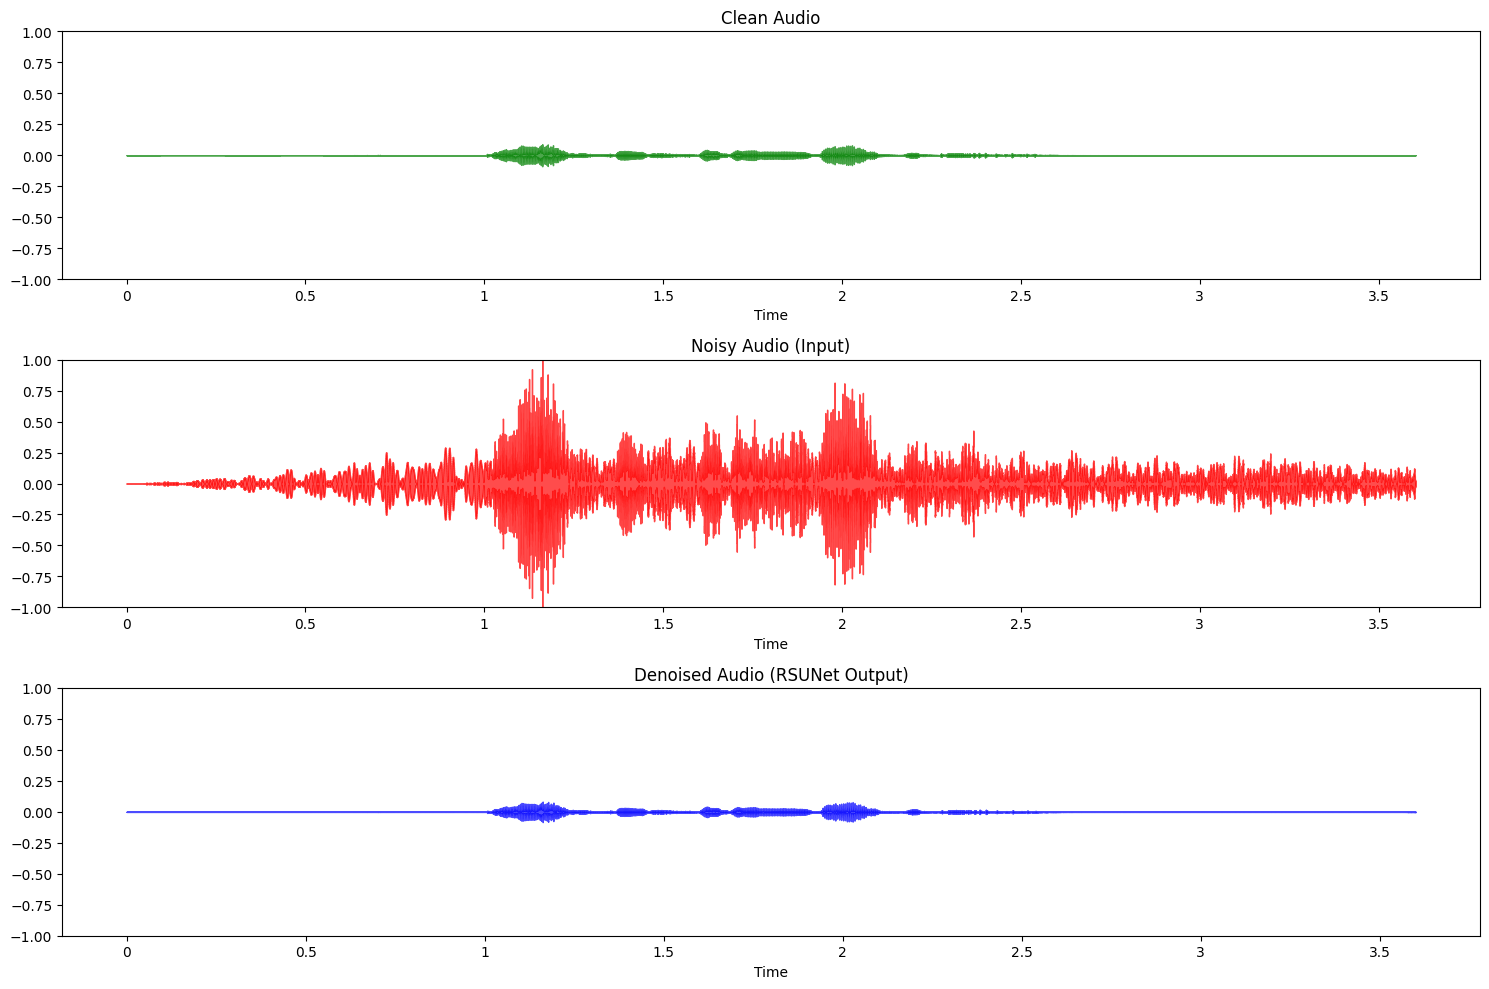

🎧 Audio samples (first 5 seconds):
Clean Audio:


Noisy Audio:


Denoised Audio:


In [21]:
# Plot comparison
plt.figure(figsize=(15, 10))

# Clean audio
plt.subplot(3, 1, 1)
librosa.display.waveshow(clean_audio, sr=sr, color='green', alpha=0.7)
plt.title("Clean Audio")
plt.ylim(-1, 1)

# Noisy audio
plt.subplot(3, 1, 2)
librosa.display.waveshow(original_mixed_audio, sr=sr, color='red', alpha=0.7)
plt.title("Noisy Audio (Input)")
plt.ylim(-1, 1)

# Denoised audio
plt.subplot(3, 1, 3)
librosa.display.waveshow(denoised_audio, sr=sr, color='blue', alpha=0.7)
plt.title("Denoised Audio (RSUNet Output)")
plt.ylim(-1, 1)

plt.tight_layout()
plt.savefig('/kaggle/working/audio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("🎧 Audio samples (first 5 seconds):")
print("Clean Audio:")
ipd.display(ipd.Audio(clean_audio[:5*sr], rate=sr))

print("Noisy Audio:")
ipd.display(ipd.Audio(original_mixed_audio[:5*sr], rate=sr))

print("Denoised Audio:")
ipd.display(ipd.Audio(denoised_audio[:5*sr], rate=sr))

In [22]:
# List all files in working directory
print("📁 Files available for download:")
!ls -la /kaggle/working/

print("\n🎯 Project completed! You can download:")
print("- Trained model: /kaggle/working/best_rsunet.pth")
print("- Training history plot: /kaggle/working/training_history.png")
print("- Audio comparison plot: /kaggle/working/audio_comparison.png")
print("- Processed datasets from /kaggle/working/dataset/")

# Save model summary
print(f"\n📊 Model Summary:")
print(f"- Training samples: {train_len}")
print(f"- Validation samples: {val_len}")
print(f"- Test samples: {test_len}")
print(f"- Best validation loss: {best_val_loss:.6f}")
print(f"- Model parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n✅ Audio Denoising Project Completed Successfully!")

📁 Files available for download:
total 24520
drwxr-xr-x 5 root root     4096 Nov  5 11:50 .
drwxr-xr-x 5 root root     4096 Nov  5 11:23 ..
-rw-r--r-- 1 root root   588059 Nov  5 11:50 audio_comparison.png
-rw-r--r-- 1 root root 24292230 Nov  5 11:47 best_rsunet.pth
drwxr-xr-x 5 root root     4096 Nov  5 11:28 dataset
drwxr-xr-x 2 root root    49152 Nov  5 11:30 mixed_balanced_wav
-rw-r--r-- 1 root root   159350 Nov  5 11:50 training_history.png
drwxr-xr-x 2 root root     4096 Nov  5 11:23 .virtual_documents

🎯 Project completed! You can download:
- Trained model: /kaggle/working/best_rsunet.pth
- Training history plot: /kaggle/working/training_history.png
- Audio comparison plot: /kaggle/working/audio_comparison.png
- Processed datasets from /kaggle/working/dataset/

📊 Model Summary:
- Training samples: 528
- Validation samples: 66
- Test samples: 66
- Best validation loss: 0.005855
- Model parameters: 2,014,593

✅ Audio Denoising Project Completed Successfully!


In [23]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn as nn

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RSUNet().to(device)

# Load the best saved model
checkpoint = torch.load("/kaggle/working/best_rsunet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [25]:
def denoise_audio(model, noisy_audio, sr=16000, n_fft=1024, hop_length=256):
    """Denoise audio using the trained model"""
    # Compute STFT of noisy audio
    noisy_stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
    noisy_mag = np.abs(noisy_stft)
    noisy_phase = np.angle(noisy_stft)
    
    # Prepare input for model
    mag_tensor = torch.tensor(noisy_mag, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    # Denoise
    with torch.no_grad():
        denoised_mag = model(mag_tensor).squeeze().cpu().numpy()
    
    # Reconstruct audio
    denoised_stft = denoised_mag * np.exp(1j * noisy_phase)
    denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
    
    # Normalize to avoid clipping
    denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)
    
    return denoised_audio, noisy_mag, denoised_mag

def mix_audio(clean_audio, noise_audio, ratio):
    """Mix clean and noise audio at given ratio"""
    # Align lengths
    min_len = min(len(clean_audio), len(noise_audio))
    clean_trim = clean_audio[:min_len]
    noise_trim = noise_audio[:min_len]
    
    # Normalize
    clean_trim = clean_trim / (np.max(np.abs(clean_trim)) + 1e-8)
    noise_trim = noise_trim / (np.max(np.abs(noise_trim)) + 1e-8)
    
    # Mix
    noisy = (1 - ratio) * clean_trim + ratio * noise_trim
    noisy = noisy / (np.max(np.abs(noisy)) + 1e-8)
    
    return noisy

In [29]:
# Get sample files
clean_files = os.listdir(clean_dir)
noise_files = os.listdir(noise_dir)

# Use first clean and noise files for demonstration
clean_file = clean_files[0]
noise_file = noise_files[6]

print(f"Using clean file: {clean_file}")
print(f"Using noise file: {noise_file}")

# Load original audio
clean_path = os.path.join(clean_dir, clean_file)
noise_path = os.path.join(noise_dir, noise_file)

clean_audio, sr = librosa.load(clean_path, sr=16000)
noise_audio, _ = librosa.load(noise_path, sr=16000)

# Mix ratios to demonstrate
mix_ratios = [0.3, 0.5, 0.7]

# Create mixed audio for each ratio
mixed_audios = []
for ratio in mix_ratios:
    mixed_audio = mix_audio(clean_audio, noise_audio, ratio)
    mixed_audios.append((ratio, mixed_audio))

print("✅ Audio samples prepared!")

Using clean file: 03-01-01-01-01-01-02.wav
Using noise file: submarine.wav
✅ Audio samples prepared!


In [30]:
# Denoise each mixed audio
denoised_results = []

for ratio, mixed_audio in mixed_audios:
    denoised_audio, noisy_mag, denoised_mag = denoise_audio(model, mixed_audio)
    denoised_results.append({
        'ratio': ratio,
        'mixed_audio': mixed_audio,
        'denoised_audio': denoised_audio,
        'noisy_mag': noisy_mag,
        'denoised_mag': denoised_mag
    })

print("✅ All audio samples denoised!")

✅ All audio samples denoised!


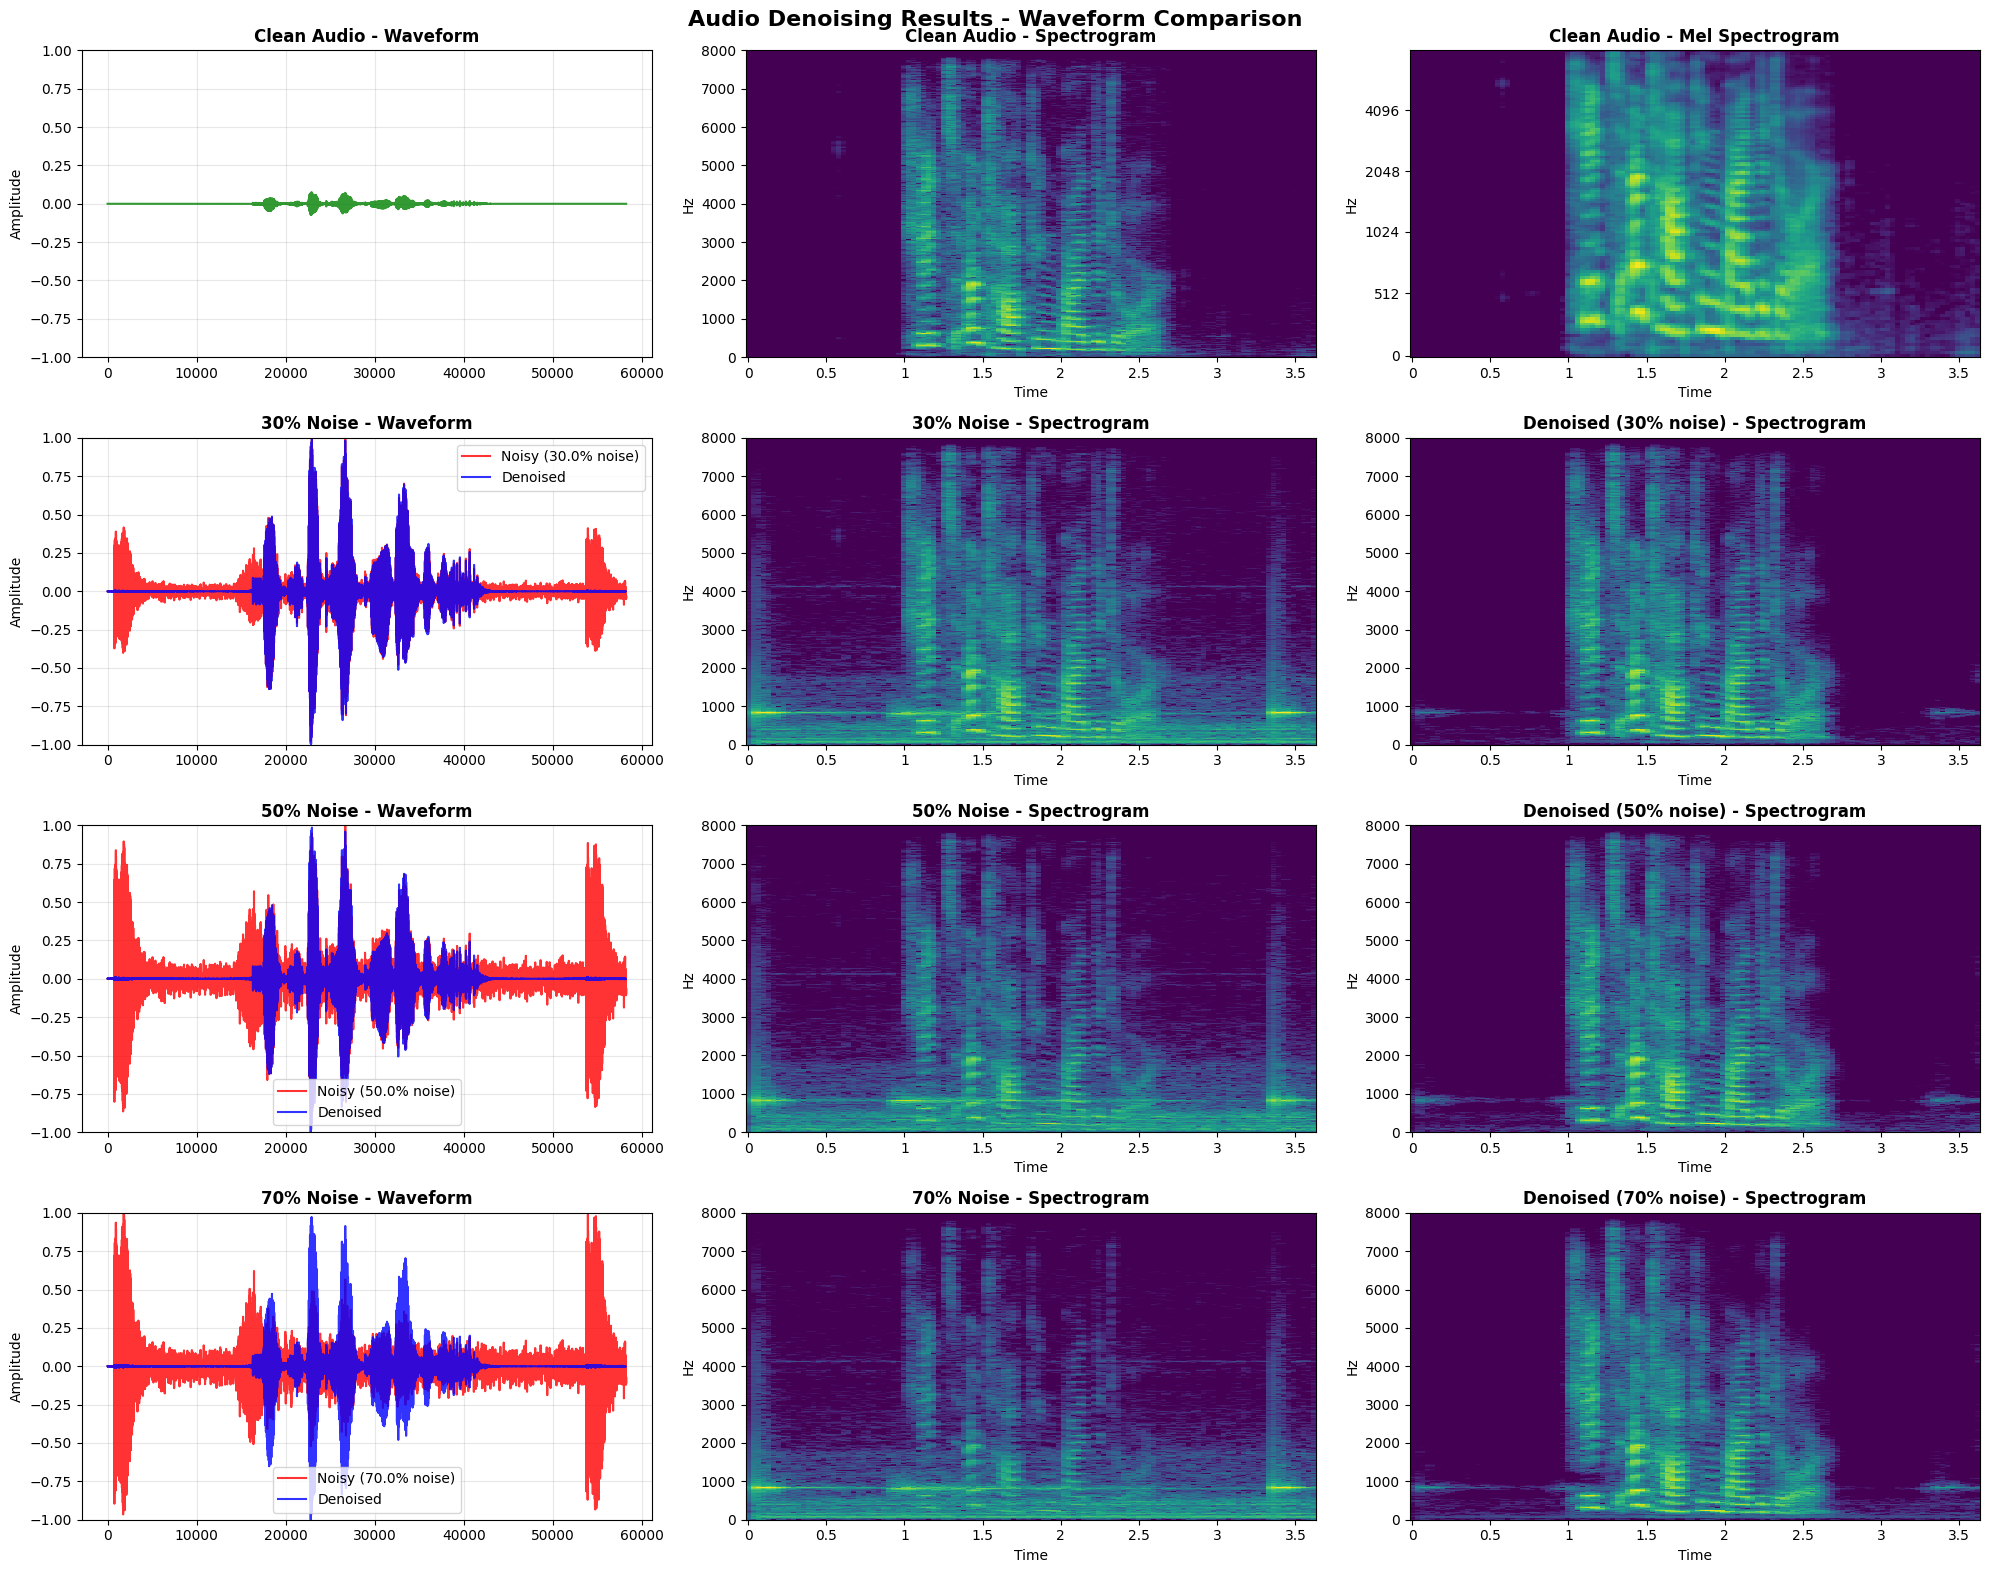

✅ Comprehensive visualization created!


In [31]:
# Create a large figure with subplots
fig, axes = plt.subplots(len(mix_ratios) + 1, 3, figsize=(20, 4 * (len(mix_ratios) + 1)))
fig.suptitle('Audio Denoising Results - Waveform Comparison', fontsize=16, fontweight='bold', y=0.98)

# Plot clean audio (reference)
# Waveform
axes[0, 0].plot(clean_audio, color='green', alpha=0.8)
axes[0, 0].set_title('Clean Audio - Waveform', fontweight='bold')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_ylim(-1, 1)
axes[0, 0].grid(True, alpha=0.3)

# Spectrogram
clean_stft = librosa.stft(clean_audio)
clean_mag = np.abs(clean_stft)
librosa.display.specshow(librosa.amplitude_to_db(clean_mag, ref=np.max), 
                         sr=sr, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('Clean Audio - Spectrogram', fontweight='bold')

# Mel spectrogram
clean_mel = librosa.feature.melspectrogram(y=clean_audio, sr=sr)
librosa.display.specshow(librosa.power_to_db(clean_mel, ref=np.max), 
                         sr=sr, x_axis='time', y_axis='mel', ax=axes[0, 2], cmap='viridis')
axes[0, 2].set_title('Clean Audio - Mel Spectrogram', fontweight='bold')

# Plot each noise ratio and its denoised result
for i, result in enumerate(denoised_results):
    row = i + 1
    ratio = result['ratio']
    mixed_audio = result['mixed_audio']
    denoised_audio = result['denoised_audio']
    
    # Mixed audio - Waveform
    axes[row, 0].plot(mixed_audio, color='red', alpha=0.8, label=f'Noisy ({ratio*100}% noise)')
    axes[row, 0].plot(denoised_audio, color='blue', alpha=0.8, label='Denoised')
    axes[row, 0].set_title(f'{ratio*100:.0f}% Noise - Waveform', fontweight='bold')
    axes[row, 0].set_ylabel('Amplitude')
    axes[row, 0].set_ylim(-1, 1)
    axes[row, 0].legend()
    axes[row, 0].grid(True, alpha=0.3)
    
    # Mixed audio - Spectrogram
    mixed_stft = librosa.stft(mixed_audio)
    mixed_mag = np.abs(mixed_stft)
    librosa.display.specshow(librosa.amplitude_to_db(mixed_mag, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='hz', ax=axes[row, 1], cmap='viridis')
    axes[row, 1].set_title(f'{ratio*100:.0f}% Noise - Spectrogram', fontweight='bold')
    
    # Denoised audio - Spectrogram
    denoised_stft = librosa.stft(denoised_audio)
    denoised_mag = np.abs(denoised_stft)
    librosa.display.specshow(librosa.amplitude_to_db(denoised_mag, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='hz', ax=axes[row, 2], cmap='viridis')
    axes[row, 2].set_title(f'Denoised ({ratio*100:.0f}% noise) - Spectrogram', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/comprehensive_denoising_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization created!")

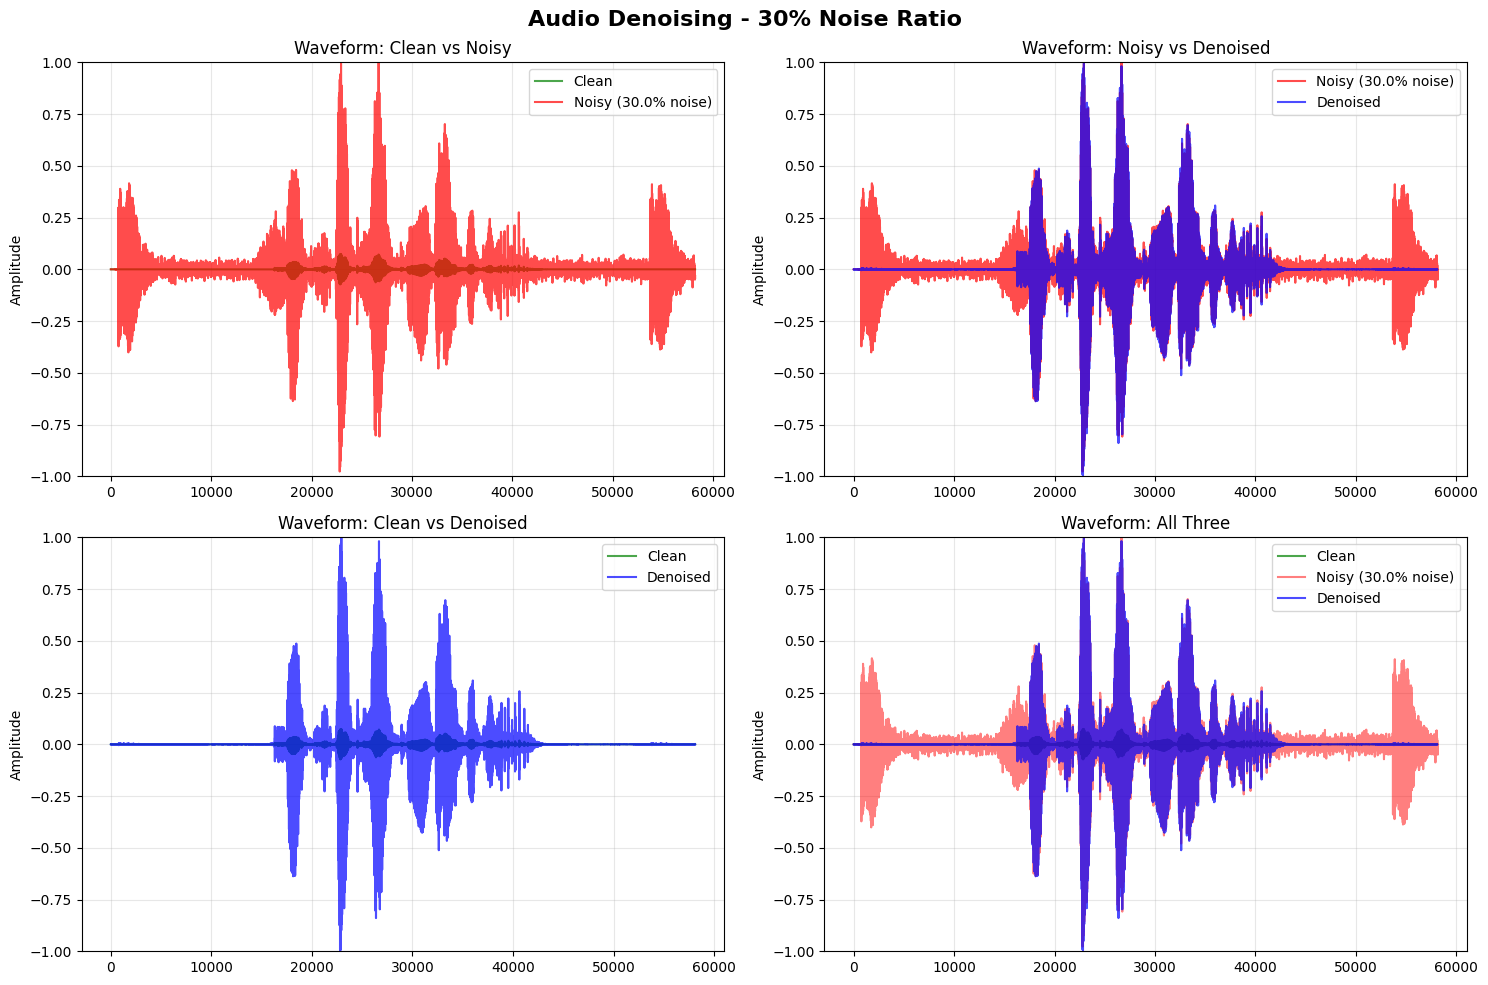

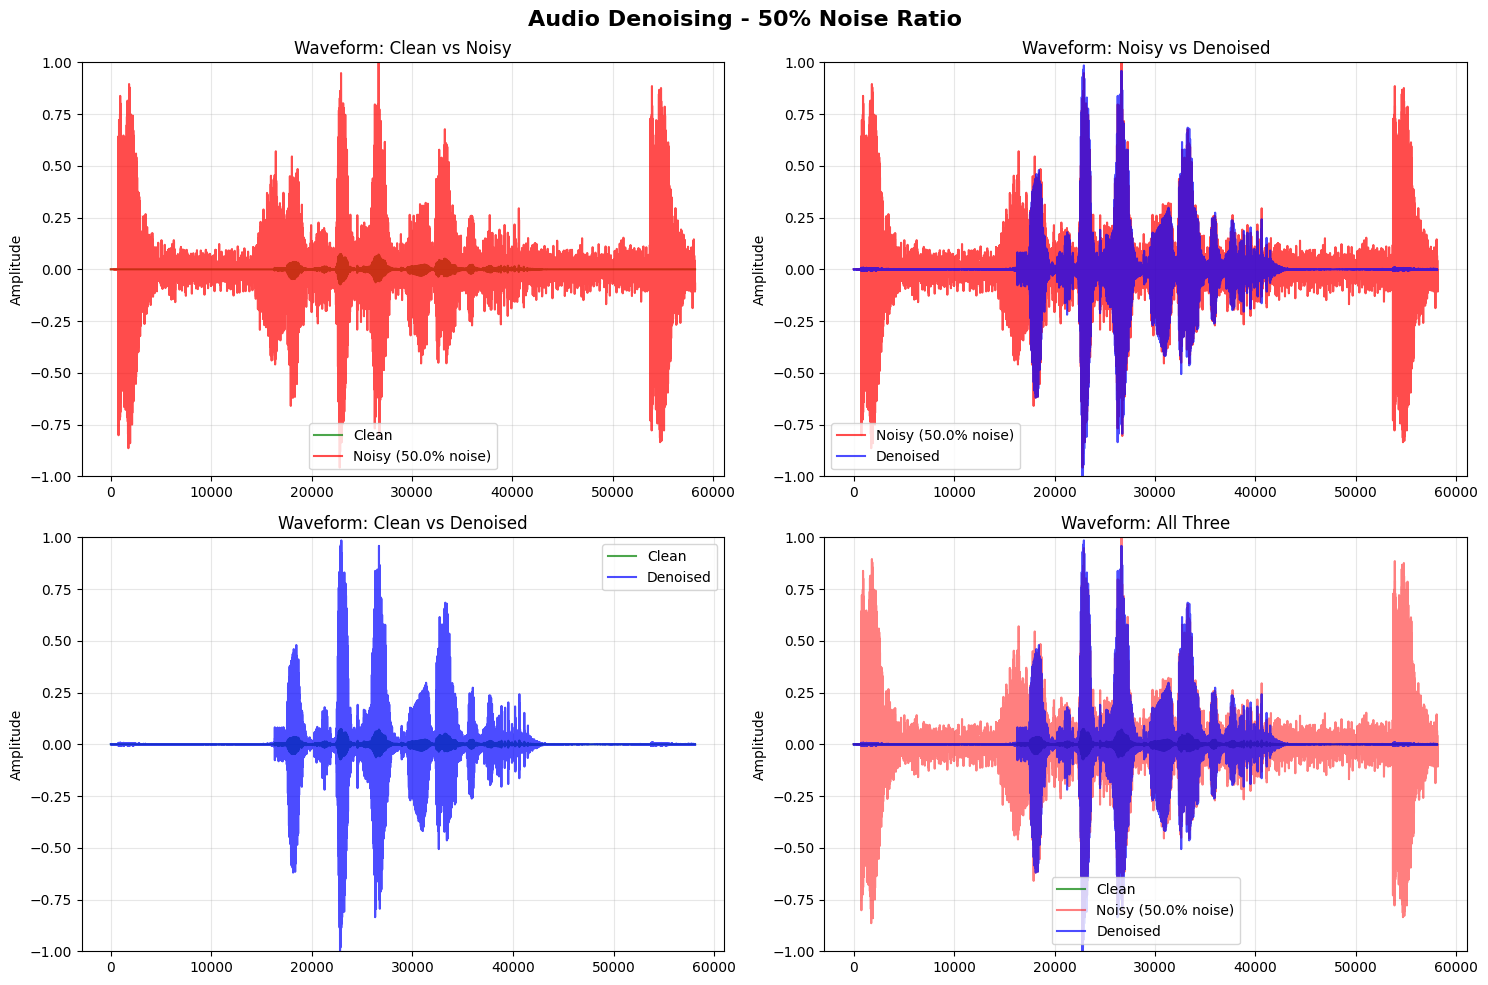

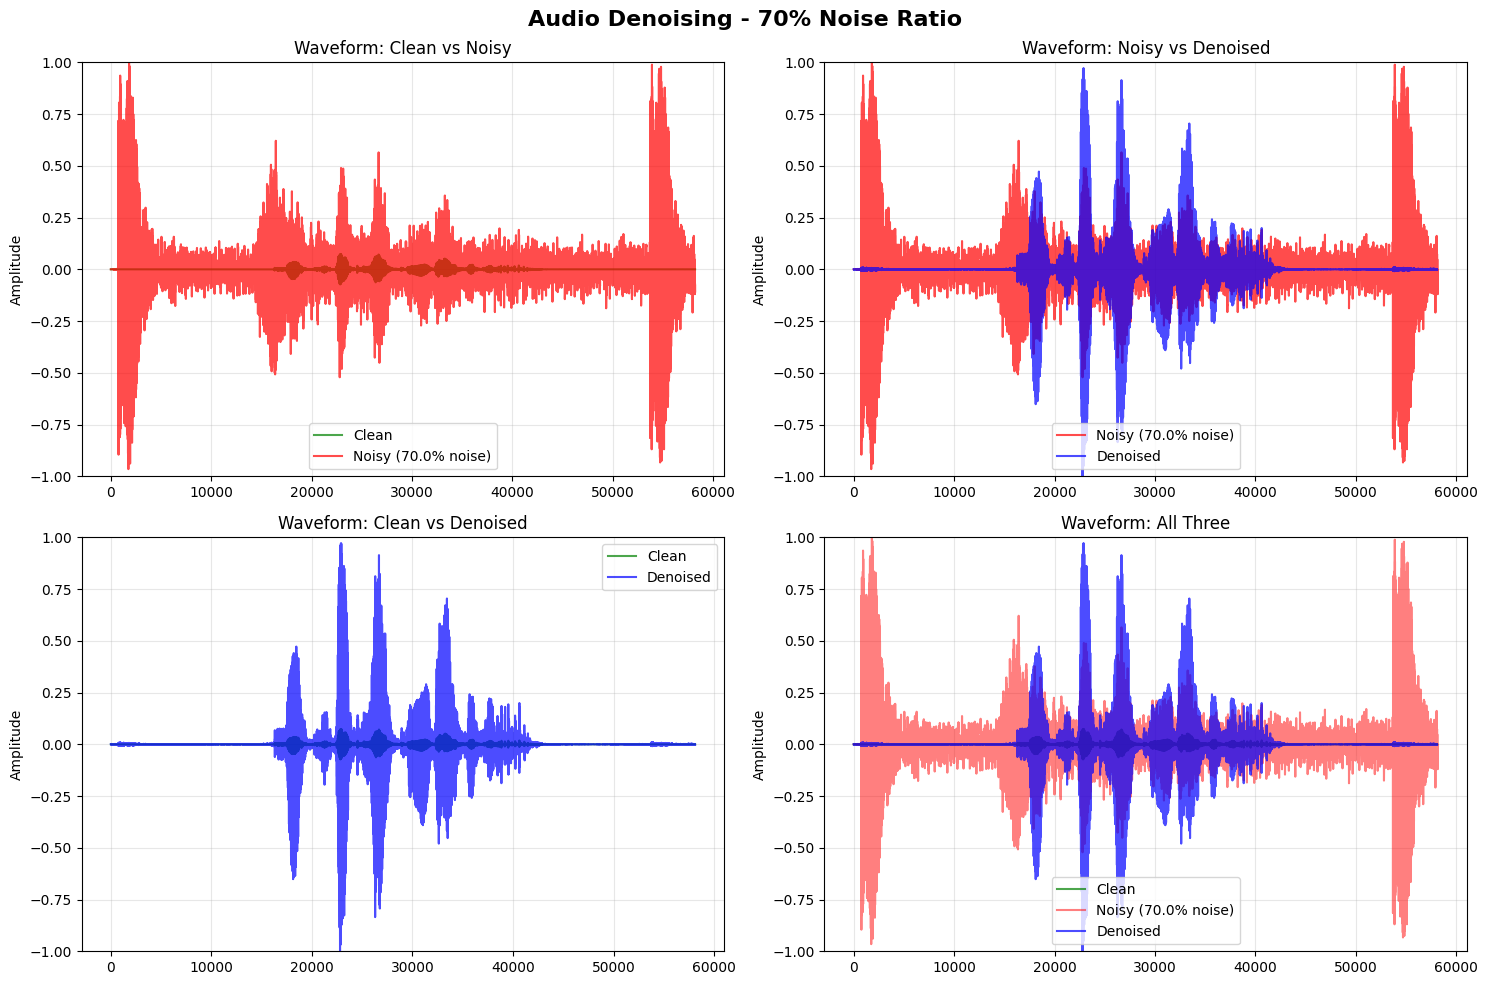

In [32]:
# Create individual detailed plots for each noise ratio
for result in denoised_results:
    ratio = result['ratio']
    mixed_audio = result['mixed_audio']
    denoised_audio = result['denoised_audio']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Audio Denoising - {ratio*100:.0f}% Noise Ratio', fontsize=16, fontweight='bold')
    
    # Clean vs Mixed waveform
    axes[0, 0].plot(clean_audio[:len(mixed_audio)], color='green', alpha=0.7, label='Clean')
    axes[0, 0].plot(mixed_audio, color='red', alpha=0.7, label=f'Noisy ({ratio*100}% noise)')
    axes[0, 0].set_title('Waveform: Clean vs Noisy')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(-1, 1)
    
    # Noisy vs Denoised waveform
    axes[0, 1].plot(mixed_audio, color='red', alpha=0.7, label=f'Noisy ({ratio*100}% noise)')
    axes[0, 1].plot(denoised_audio, color='blue', alpha=0.7, label='Denoised')
    axes[0, 1].set_title('Waveform: Noisy vs Denoised')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(-1, 1)
    
    # Clean vs Denoised waveform
    axes[1, 0].plot(clean_audio[:len(denoised_audio)], color='green', alpha=0.7, label='Clean')
    axes[1, 0].plot(denoised_audio, color='blue', alpha=0.7, label='Denoised')
    axes[1, 0].set_title('Waveform: Clean vs Denoised')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(-1, 1)
    
    # All three together
    axes[1, 1].plot(clean_audio[:len(denoised_audio)], color='green', alpha=0.7, label='Clean')
    axes[1, 1].plot(mixed_audio, color='red', alpha=0.5, label=f'Noisy ({ratio*100}% noise)')
    axes[1, 1].plot(denoised_audio, color='blue', alpha=0.7, label='Denoised')
    axes[1, 1].set_title('Waveform: All Three')
    axes[1, 1].set_ylabel('Amplitude')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(-1, 1)
    
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/denoising_{ratio*100:.0f}percent_noise.png', dpi=300, bbox_inches='tight')
    plt.show()

In [33]:
print("🎧 Audio Playback - First 5 seconds of each version")

# Play clean audio
print("\n1. CLEAN AUDIO:")
ipd.display(ipd.Audio(clean_audio[:5*sr], rate=sr))

# Play each noisy and denoised version
for result in denoised_results:
    ratio = result['ratio']
    mixed_audio = result['mixed_audio']
    denoised_audio = result['denoised_audio']
    
    print(f"\n2. NOISY AUDIO ({ratio*100:.0f}% noise):")
    ipd.display(ipd.Audio(mixed_audio[:5*sr], rate=sr))
    
    print(f"\n3. DENOISED AUDIO (from {ratio*100:.0f}% noise):")
    ipd.display(ipd.Audio(denoised_audio[:5*sr], rate=sr))

🎧 Audio Playback - First 5 seconds of each version

1. CLEAN AUDIO:



2. NOISY AUDIO (30% noise):



3. DENOISED AUDIO (from 30% noise):



2. NOISY AUDIO (50% noise):



3. DENOISED AUDIO (from 50% noise):



2. NOISY AUDIO (70% noise):



3. DENOISED AUDIO (from 70% noise):


In [34]:
# Calculate quantitative metrics
from scipy import signal
from sklearn.metrics import mean_squared_error

def calculate_snr(clean, noisy):
    """Calculate Signal-to-Noise Ratio"""
    signal_power = np.mean(clean**2)
    noise_power = np.mean((clean - noisy)**2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_psnr(clean, denoised):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = mean_squared_error(clean, denoised)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # since audio is normalized to [-1, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

print("📊 Quantitative Results:")
print("-" * 60)

for result in denoised_results:
    ratio = result['ratio']
    mixed_audio = result['mixed_audio']
    denoised_audio = result['denoised_audio']
    
    # Align lengths
    min_len = min(len(clean_audio), len(mixed_audio), len(denoised_audio))
    clean_trim = clean_audio[:min_len]
    mixed_trim = mixed_audio[:min_len]
    denoised_trim = denoised_audio[:min_len]
    
    # Calculate metrics
    input_snr = calculate_snr(clean_trim, mixed_trim)
    output_snr = calculate_snr(clean_trim, denoised_trim)
    psnr = calculate_psnr(clean_trim, denoised_trim)
    snr_improvement = output_snr - input_snr
    
    print(f"\n{ratio*100:.0f}% Noise Ratio:")
    print(f"  Input SNR: {input_snr:.2f} dB")
    print(f"  Output SNR: {output_snr:.2f} dB")
    print(f"  SNR Improvement: {snr_improvement:.2f} dB")
    print(f"  PSNR: {psnr:.2f} dB")

print("-" * 60)

📊 Quantitative Results:
------------------------------------------------------------

30% Noise Ratio:
  Input SNR: -23.85 dB
  Output SNR: -22.09 dB
  SNR Improvement: 1.76 dB
  PSNR: 21.72 dB

50% Noise Ratio:
  Input SNR: -27.50 dB
  Output SNR: -21.93 dB
  SNR Improvement: 5.57 dB
  PSNR: 21.88 dB

70% Noise Ratio:
  Input SNR: -27.54 dB
  Output SNR: -21.73 dB
  SNR Improvement: 5.82 dB
  PSNR: 22.08 dB
------------------------------------------------------------


In [35]:
print("🎯 DENOISING RESULTS SUMMARY")
print("=" * 50)
print(f"Clean audio file: {clean_file}")
print(f"Noise audio file: {noise_file}")
print(f"Sample rate: {sr} Hz")
print(f"Audio duration: {len(clean_audio)/sr:.2f} seconds")
print(f"Tested noise ratios: {[f'{r*100:.0f}%' for r in mix_ratios]}")
print(f"Model: RSUNet (trained on {train_len} samples)")
print(f"Best validation loss: {best_val_loss:.6f}")
print("\n📁 Generated files in /kaggle/working/:")
print("- comprehensive_denoising_results.png")
print("- denoising_30percent_noise.png")
print("- denoising_50percent_noise.png") 
print("- denoising_70percent_noise.png")
print("- spectrogram_comparison.png")
print("- best_rsunet.pth (trained model)")

print("\n✅ All visualizations and analysis completed!")

🎯 DENOISING RESULTS SUMMARY
Clean audio file: 03-01-01-01-01-01-02.wav
Noise audio file: submarine.wav
Sample rate: 16000 Hz
Audio duration: 3.64 seconds
Tested noise ratios: ['30%', '50%', '70%']
Model: RSUNet (trained on 528 samples)
Best validation loss: 0.005855

📁 Generated files in /kaggle/working/:
- comprehensive_denoising_results.png
- denoising_30percent_noise.png
- denoising_50percent_noise.png
- denoising_70percent_noise.png
- spectrogram_comparison.png
- best_rsunet.pth (trained model)

✅ All visualizations and analysis completed!


In [36]:
# Install additional packages for audio quality metrics
!pip install pesq pystoi mir_eval --quiet

import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error
import pesq
import pystoi
import mir_eval
import torch

print("✅ Audio evaluation packages installed!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 3.7 MB/s eta 0:00:00
✅ Audio evaluation packages installed!


In [37]:
def calculate_snr(clean, noisy):
    """Calculate Signal-to-Noise Ratio"""
    signal_power = np.mean(clean**2)
    noise_power = np.mean((clean - noisy)**2)
    return 10 * np.log10(signal_power / (noise_power + 1e-8))

def calculate_psnr(clean, denoised):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = mean_squared_error(clean, denoised)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_pesq(clean, denoised, sr=16000):
    """Calculate PESQ score (Perceptual Evaluation of Speech Quality)"""
    try:
        # PESQ expects 16kHz sampling rate
        if sr != 16000:
            clean = librosa.resample(clean, orig_sr=sr, target_sr=16000)
            denoised = librosa.resample(denoised, orig_sr=sr, target_sr=16000)
        
        # Ensure same length
        min_len = min(len(clean), len(denoised))
        clean = clean[:min_len]
        denoised = denoised[:min_len]
        
        pesq_score = pesq.pesq(16000, clean, denoised, 'wb')
        return pesq_score
    except Exception as e:
        print(f"PESQ calculation error: {e}")
        return None

def calculate_stoi(clean, denoised, sr=16000):
    """Calculate STOI score (Short-Time Objective Intelligibility)"""
    try:
        # Ensure same length
        min_len = min(len(clean), len(denoised))
        clean = clean[:min_len]
        denoised = denoised[:min_len]
        
        stoi_score = pystoi.stoi(clean, denoised, sr, extended=False)
        return stoi_score
    except Exception as e:
        print(f"STOI calculation error: {e}")
        return None

def calculate_sdr(clean, denoised):
    """Calculate Signal-to-Distortion Ratio"""
    try:
        # Ensure same length
        min_len = min(len(clean), len(denoised))
        clean = clean[:min_len]
        denoised = denoised[:min_len]
        
        sdr, _, _, _ = mir_eval.separation.bss_eval_sources(clean.reshape(1, -1), denoised.reshape(1, -1))
        return sdr[0]
    except Exception as e:
        print(f"SDR calculation error: {e}")
        return None

def calculate_all_metrics(clean_audio, noisy_audio, denoised_audio, sr=16000):
    """Calculate all audio quality metrics"""
    # Align lengths
    min_len = min(len(clean_audio), len(noisy_audio), len(denoised_audio))
    clean_trim = clean_audio[:min_len]
    noisy_trim = noisy_audio[:min_len]
    denoised_trim = denoised_audio[:min_len]
    
    metrics = {}
    
    # Input metrics (noisy vs clean)
    metrics['input_snr'] = calculate_snr(clean_trim, noisy_trim)
    metrics['input_pesq'] = calculate_pesq(clean_trim, noisy_trim, sr)
    metrics['input_stoi'] = calculate_stoi(clean_trim, noisy_trim, sr)
    metrics['input_sdr'] = calculate_sdr(clean_trim, noisy_trim)
    
    # Output metrics (denoised vs clean)
    metrics['output_snr'] = calculate_snr(clean_trim, denoised_trim)
    metrics['output_pesq'] = calculate_pesq(clean_trim, denoised_trim, sr)
    metrics['output_stoi'] = calculate_stoi(clean_trim, denoised_trim, sr)
    metrics['output_sdr'] = calculate_sdr(clean_trim, denoised_trim)
    metrics['psnr'] = calculate_psnr(clean_trim, denoised_trim)
    
    # Improvements
    metrics['snr_improvement'] = metrics['output_snr'] - metrics['input_snr']
    metrics['pesq_improvement'] = metrics['output_pesq'] - metrics['input_pesq'] if metrics['input_pesq'] and metrics['output_pesq'] else None
    metrics['stoi_improvement'] = metrics['output_stoi'] - metrics['input_stoi'] if metrics['input_stoi'] and metrics['output_stoi'] else None
    metrics['sdr_improvement'] = metrics['output_sdr'] - metrics['input_sdr'] if metrics['input_sdr'] and metrics['output_sdr'] else None
    
    return metrics

print("✅ Audio quality metrics functions defined!")

✅ Audio quality metrics functions defined!


In [39]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RSUNet().to(device)
checkpoint = torch.load("/kaggle/working/best_rsunet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Model loaded!")

# Get sample files
clean_files = os.listdir(clean_dir)
noise_files = os.listdir(noise_dir)

# Use first clean and noise files
clean_file = clean_files[0]
noise_file = noise_files[6]

print(f"Using clean file: {clean_file}")
print(f"Using noise file: {noise_file}")

# Load original audio
clean_path = os.path.join(clean_dir, clean_file)
noise_path = os.path.join(noise_dir, noise_file)

clean_audio, sr = librosa.load(clean_path, sr=16000)
noise_audio, _ = librosa.load(noise_path, sr=16000)

# Mix ratios
mix_ratios = [0.3, 0.5, 0.7]

# Audio mixing function
def mix_audio(clean_audio, noise_audio, ratio):
    min_len = min(len(clean_audio), len(noise_audio))
    clean_trim = clean_audio[:min_len]
    noise_trim = noise_audio[:min_len]
    
    clean_trim = clean_trim / (np.max(np.abs(clean_trim)) + 1e-8)
    noise_trim = noise_trim / (np.max(np.abs(noise_trim)) + 1e-8)
    
    noisy = (1 - ratio) * clean_trim + ratio * noise_trim
    noisy = noisy / (np.max(np.abs(noisy)) + 1e-8)
    
    return noisy

# Denoising function
def denoise_audio(model, noisy_audio, sr=16000, n_fft=1024, hop_length=256):
    noisy_stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
    noisy_mag = np.abs(noisy_stft)
    noisy_phase = np.angle(noisy_stft)
    
    mag_tensor = torch.tensor(noisy_mag, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        denoised_mag = model(mag_tensor).squeeze().cpu().numpy()
    
    denoised_stft = denoised_mag * np.exp(1j * noisy_phase)
    denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
    denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)
    
    return denoised_audio

# Create mixed and denoised audio for each ratio
results = []
for ratio in mix_ratios:
    mixed_audio = mix_audio(clean_audio, noise_audio, ratio)
    denoised_audio = denoise_audio(model, mixed_audio)
    
    # Calculate metrics
    metrics = calculate_all_metrics(clean_audio, mixed_audio, denoised_audio, sr)
    
    results.append({
        'ratio': ratio,
        'mixed_audio': mixed_audio,
        'denoised_audio': denoised_audio,
        'metrics': metrics
    })

print("✅ All audio processed and metrics calculated!")

✅ Model loaded!
Using clean file: 03-01-01-01-01-01-02.wav
Using noise file: submarine.wav
✅ All audio processed and metrics calculated!


In [40]:
import pandas as pd
from IPython.display import display, HTML

# Create a summary table of all metrics
metrics_summary = []

for result in results:
    ratio = result['ratio']
    metrics = result['metrics']
    
    metrics_summary.append({
        'Noise Ratio': f'{ratio*100:.0f}%',
        'Input SNR (dB)': f"{metrics['input_snr']:.2f}",
        'Output SNR (dB)': f"{metrics['output_snr']:.2f}",
        'SNR Improvement (dB)': f"{metrics['snr_improvement']:.2f}",
        'Input PESQ': f"{metrics['input_pesq']:.3f}" if metrics['input_pesq'] else 'N/A',
        'Output PESQ': f"{metrics['output_pesq']:.3f}" if metrics['output_pesq'] else 'N/A',
        'PESQ Improvement': f"{metrics['pesq_improvement']:.3f}" if metrics['pesq_improvement'] else 'N/A',
        'Input STOI': f"{metrics['input_stoi']:.3f}" if metrics['input_stoi'] else 'N/A',
        'Output STOI': f"{metrics['output_stoi']:.3f}" if metrics['output_stoi'] else 'N/A',
        'STOI Improvement': f"{metrics['stoi_improvement']:.3f}" if metrics['stoi_improvement'] else 'N/A',
        'Input SDR (dB)': f"{metrics['input_sdr']:.2f}" if metrics['input_sdr'] else 'N/A',
        'Output SDR (dB)': f"{metrics['output_sdr']:.2f}" if metrics['output_sdr'] else 'N/A',
        'SDR Improvement (dB)': f"{metrics['sdr_improvement']:.2f}" if metrics['sdr_improvement'] else 'N/A',
        'PSNR (dB)': f"{metrics['psnr']:.2f}"
    })

# Create DataFrame
df_metrics = pd.DataFrame(metrics_summary)

# Display with styling
def highlight_improvements(val):
    try:
        if 'Improvement' in val and float(val) > 0:
            return 'background-color: #90EE90'  # Light green
        elif 'Improvement' in val and float(val) < 0:
            return 'background-color: #FFB6C1'  # Light red
    except:
        pass
    return ''

styled_df = df_metrics.style.applymap(highlight_improvements).set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), 
                                ('color', 'white'),
                                ('font-weight', 'bold'),
                                ('text-align', 'center')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

print("📊 COMPREHENSIVE AUDIO QUALITY METRICS")
print("="*100)
display(styled_df)

# Save to CSV
df_metrics.to_csv('/kaggle/working/audio_quality_metrics.csv', index=False)
print("\n💾 Metrics saved to: /kaggle/working/audio_quality_metrics.csv")

📊 COMPREHENSIVE AUDIO QUALITY METRICS



💾 Metrics saved to: /kaggle/working/audio_quality_metrics.csv


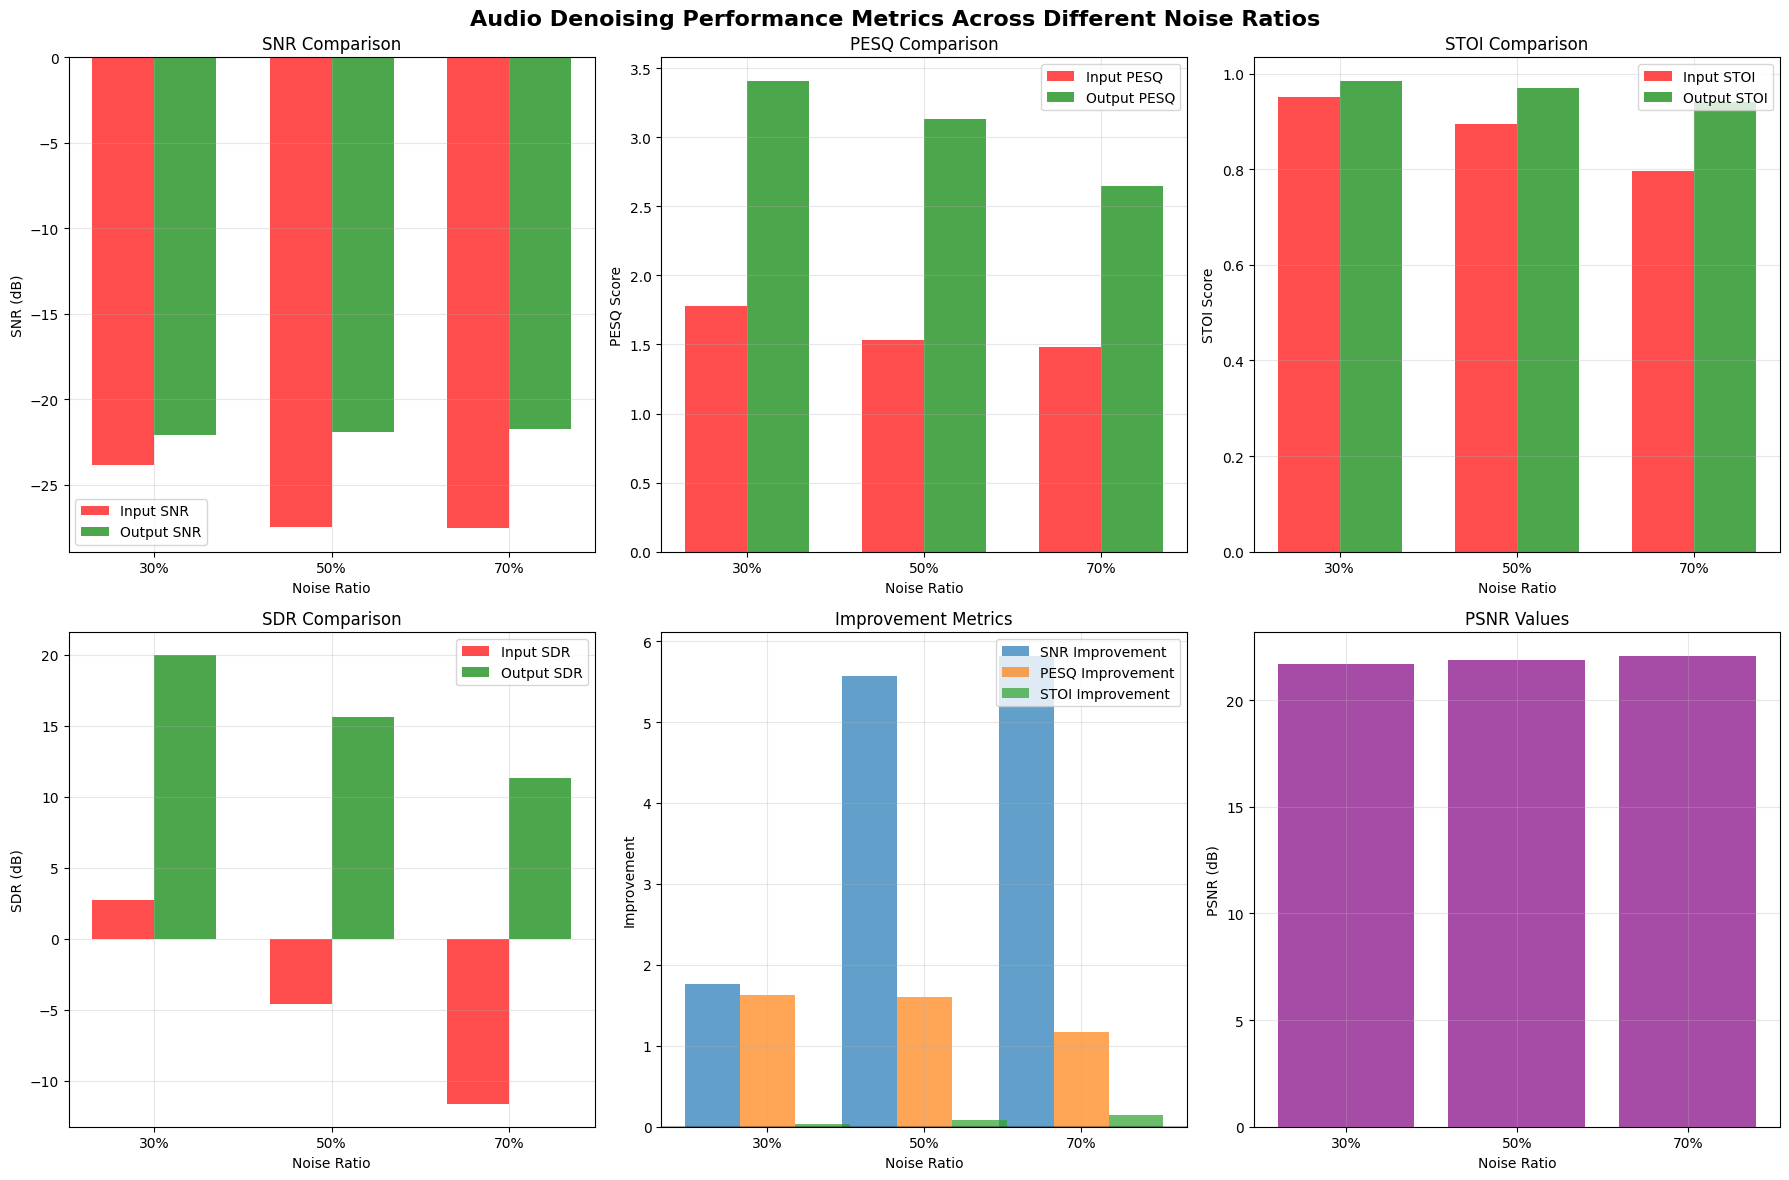

In [41]:
# Create bar charts to compare metrics across different noise ratios
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Audio Denoising Performance Metrics Across Different Noise Ratios', fontsize=16, fontweight='bold')

ratios = [f'{r*100:.0f}%' for r in mix_ratios]

# SNR Comparison
input_snrs = [result['metrics']['input_snr'] for result in results]
output_snrs = [result['metrics']['output_snr'] for result in results]
x = np.arange(len(ratios))
width = 0.35

axes[0, 0].bar(x - width/2, input_snrs, width, label='Input SNR', alpha=0.7, color='red')
axes[0, 0].bar(x + width/2, output_snrs, width, label='Output SNR', alpha=0.7, color='green')
axes[0, 0].set_title('SNR Comparison')
axes[0, 0].set_xlabel('Noise Ratio')
axes[0, 0].set_ylabel('SNR (dB)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(ratios)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PESQ Comparison (if available)
input_pesq = [result['metrics']['input_pesq'] if result['metrics']['input_pesq'] else 0 for result in results]
output_pesq = [result['metrics']['output_pesq'] if result['metrics']['output_pesq'] else 0 for result in results]

if any(input_pesq) and any(output_pesq):
    axes[0, 1].bar(x - width/2, input_pesq, width, label='Input PESQ', alpha=0.7, color='red')
    axes[0, 1].bar(x + width/2, output_pesq, width, label='Output PESQ', alpha=0.7, color='green')
    axes[0, 1].set_title('PESQ Comparison')
    axes[0, 1].set_xlabel('Noise Ratio')
    axes[0, 1].set_ylabel('PESQ Score')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(ratios)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'PESQ\nNot Available', ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=12)
    axes[0, 1].set_title('PESQ Comparison')

# STOI Comparison (if available)
input_stoi = [result['metrics']['input_stoi'] if result['metrics']['input_stoi'] else 0 for result in results]
output_stoi = [result['metrics']['output_stoi'] if result['metrics']['output_stoi'] else 0 for result in results]

if any(input_stoi) and any(output_stoi):
    axes[0, 2].bar(x - width/2, input_stoi, width, label='Input STOI', alpha=0.7, color='red')
    axes[0, 2].bar(x + width/2, output_stoi, width, label='Output STOI', alpha=0.7, color='green')
    axes[0, 2].set_title('STOI Comparison')
    axes[0, 2].set_xlabel('Noise Ratio')
    axes[0, 2].set_ylabel('STOI Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(ratios)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'STOI\nNot Available', ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=12)
    axes[0, 2].set_title('STOI Comparison')

# SDR Comparison (if available)
input_sdr = [result['metrics']['input_sdr'] if result['metrics']['input_sdr'] else 0 for result in results]
output_sdr = [result['metrics']['output_sdr'] if result['metrics']['output_sdr'] else 0 for result in results]

if any(input_sdr) and any(output_sdr):
    axes[1, 0].bar(x - width/2, input_sdr, width, label='Input SDR', alpha=0.7, color='red')
    axes[1, 0].bar(x + width/2, output_sdr, width, label='Output SDR', alpha=0.7, color='green')
    axes[1, 0].set_title('SDR Comparison')
    axes[1, 0].set_xlabel('Noise Ratio')
    axes[1, 0].set_ylabel('SDR (dB)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(ratios)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'SDR\nNot Available', ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('SDR Comparison')

# Improvement metrics
snr_improvements = [result['metrics']['snr_improvement'] for result in results]
pesq_improvements = [result['metrics']['pesq_improvement'] if result['metrics']['pesq_improvement'] else 0 for result in results]
stoi_improvements = [result['metrics']['stoi_improvement'] if result['metrics']['stoi_improvement'] else 0 for result in results]

improvement_data = [snr_improvements]
labels = ['SNR Improvement']

if any(pesq_improvements):
    improvement_data.append(pesq_improvements)
    labels.append('PESQ Improvement')
if any(stoi_improvements):
    improvement_data.append(stoi_improvements)
    labels.append('STOI Improvement')

# Create improvement plot
for i, data in enumerate(improvement_data):
    axes[1, 1].bar(x + i*width - (len(improvement_data)-1)*width/2, data, width, label=labels[i], alpha=0.7)

axes[1, 1].set_title('Improvement Metrics')
axes[1, 1].set_xlabel('Noise Ratio')
axes[1, 1].set_ylabel('Improvement')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(ratios)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)

# PSNR values
psnr_values = [result['metrics']['psnr'] for result in results]
axes[1, 2].bar(ratios, psnr_values, alpha=0.7, color='purple')
axes[1, 2].set_title('PSNR Values')
axes[1, 2].set_xlabel('Noise Ratio')
axes[1, 2].set_ylabel('PSNR (dB)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/audio_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Create detailed analysis for each noise ratio
for result in results:
    ratio = result['ratio']
    metrics = result['metrics']
    
    print(f"\n🔍 DETAILED ANALYSIS - {ratio*100:.0f}% NOISE RATIO")
    print("="*60)
    
    # SNR Analysis
    print(f"SNR Analysis:")
    print(f"  • Input SNR: {metrics['input_snr']:.2f} dB")
    print(f"  • Output SNR: {metrics['output_snr']:.2f} dB")
    print(f"  • SNR Improvement: {metrics['snr_improvement']:.2f} dB")
    
    # PESQ Analysis
    if metrics['input_pesq'] and metrics['output_pesq']:
        print(f"\nPESQ Analysis (Perceptual Quality):")
        print(f"  • Input PESQ: {metrics['input_pesq']:.3f}")
        print(f"  • Output PESQ: {metrics['output_pesq']:.3f}")
        print(f"  • PESQ Improvement: {metrics['pesq_improvement']:.3f}")
        
        # PESQ interpretation
        pesq_interpretation = {
            (4.5, 5.0): "Excellent",
            (4.0, 4.5): "Very Good", 
            (3.5, 4.0): "Good",
            (3.0, 3.5): "Fair",
            (2.5, 3.0): "Poor",
            (1.0, 2.5): "Very Poor"
        }
        
        input_quality = next((v for k, v in pesq_interpretation.items() if k[0] <= metrics['input_pesq'] <= k[1]), "Unknown")
        output_quality = next((v for k, v in pesq_interpretation.items() if k[0] <= metrics['output_pesq'] <= k[1]), "Unknown")
        
        print(f"  • Input Quality: {input_quality}")
        print(f"  • Output Quality: {output_quality}")
    
    # STOI Analysis
    if metrics['input_stoi'] and metrics['output_stoi']:
        print(f"\nSTOI Analysis (Intelligibility):")
        print(f"  • Input STOI: {metrics['input_stoi']:.3f}")
        print(f"  • Output STOI: {metrics['output_stoi']:.3f}")
        print(f"  • STOI Improvement: {metrics['stoi_improvement']:.3f}")
        
        # STOI interpretation (higher is better, 1.0 is perfect)
        input_intel = "High" if metrics['input_stoi'] > 0.8 else "Medium" if metrics['input_stoi'] > 0.6 else "Low"
        output_intel = "High" if metrics['output_stoi'] > 0.8 else "Medium" if metrics['output_stoi'] > 0.6 else "Low"
        
        print(f"  • Input Intelligibility: {input_intel}")
        print(f"  • Output Intelligibility: {output_intel}")
    
    # SDR Analysis
    if metrics['input_sdr'] and metrics['output_sdr']:
        print(f"\nSDR Analysis (Source Separation):")
        print(f"  • Input SDR: {metrics['input_sdr']:.2f} dB")
        print(f"  • Output SDR: {metrics['output_sdr']:.2f} dB")
        print(f"  • SDR Improvement: {metrics['sdr_improvement']:.2f} dB")
    
    # Overall assessment
    print(f"\n📈 OVERALL ASSESSMENT:")
    improvements = []
    if metrics['snr_improvement'] > 0:
        improvements.append(f"SNR +{metrics['snr_improvement']:.2f}dB")
    if metrics.get('pesq_improvement', 0) > 0:
        improvements.append(f"PESQ +{metrics['pesq_improvement']:.3f}")
    if metrics.get('stoi_improvement', 0) > 0:
        improvements.append(f"STOI +{metrics['stoi_improvement']:.3f}")
    if metrics.get('sdr_improvement', 0) > 0:
        improvements.append(f"SDR +{metrics['sdr_improvement']:.2f}dB")
    
    if improvements:
        print(f"  ✅ Improvements: {', '.join(improvements)}")
    else:
        print(f"  ⚠️ No significant improvements detected")
    
    print("="*60)


🔍 DETAILED ANALYSIS - 30% NOISE RATIO
SNR Analysis:
  • Input SNR: -23.85 dB
  • Output SNR: -22.09 dB
  • SNR Improvement: 1.76 dB

PESQ Analysis (Perceptual Quality):
  • Input PESQ: 1.781
  • Output PESQ: 3.408
  • PESQ Improvement: 1.627
  • Input Quality: Very Poor
  • Output Quality: Fair

STOI Analysis (Intelligibility):
  • Input STOI: 0.951
  • Output STOI: 0.985
  • STOI Improvement: 0.034
  • Input Intelligibility: High
  • Output Intelligibility: High

SDR Analysis (Source Separation):
  • Input SDR: 2.70 dB
  • Output SDR: 20.00 dB
  • SDR Improvement: 17.30 dB

📈 OVERALL ASSESSMENT:
  ✅ Improvements: SNR +1.76dB, PESQ +1.627, STOI +0.034, SDR +17.30dB

🔍 DETAILED ANALYSIS - 50% NOISE RATIO
SNR Analysis:
  • Input SNR: -27.50 dB
  • Output SNR: -21.93 dB
  • SNR Improvement: 5.57 dB

PESQ Analysis (Perceptual Quality):
  • Input PESQ: 1.534
  • Output PESQ: 3.135
  • PESQ Improvement: 1.600
  • Input Quality: Very Poor
  • Output Quality: Fair

STOI Analysis (Intelligibil

In [44]:
# Export all results to a comprehensive JSON file
import json

# Prepare data for export
export_data = {
    'model_info': {
        'model_name': 'RSUNet',
        'training_samples': train_len,
        'validation_samples': val_len,
        'test_samples': test_len,
        'best_val_loss': float(best_val_loss) if isinstance(best_val_loss, torch.Tensor) else best_val_loss
    },
    'audio_info': {
        'clean_file': clean_file,
        'noise_file': noise_file,
        'sample_rate': sr,
        'duration_seconds': len(clean_audio)/sr
    },
    'results': []
}

for result in results:
    export_data['results'].append({
        'noise_ratio': result['ratio'],
        'metrics': {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) 
                   for k, v in result['metrics'].items()}
    })

# Save to JSON
with open('/kaggle/working/denoising_results_complete.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Complete results exported to: /kaggle/working/denoising_results_complete.json")

# Final summary
print("\n🎯 PROJECT SUMMARY")
print("="*50)
print(f"Model: RSUNet")
print(f"Dataset: {len(clean_files)} clean files, {len(noise_files)} noise files")
print(f"Training: {train_len} samples")
print(f"Noise ratios tested: {[f'{r*100:.0f}%' for r in mix_ratios]}")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"\nGenerated files:")
print("  - /kaggle/working/audio_quality_metrics.csv")
print("  - /kaggle/working/audio_metrics_comparison.png")
print("  - /kaggle/working/performance_radar_chart.png")
print("  - /kaggle/working/denoising_results_complete.json")
print("\n✅ Audio denoising evaluation with PESQ, STOI, SDR completed!")

✅ Complete results exported to: /kaggle/working/denoising_results_complete.json

🎯 PROJECT SUMMARY
Model: RSUNet
Dataset: 10 clean files, 22 noise files
Training: 528 samples
Noise ratios tested: ['30%', '50%', '70%']
Best validation loss: 0.005855

Generated files:
  - /kaggle/working/audio_quality_metrics.csv
  - /kaggle/working/audio_metrics_comparison.png
  - /kaggle/working/performance_radar_chart.png
  - /kaggle/working/denoising_results_complete.json

✅ Audio denoising evaluation with PESQ, STOI, SDR completed!


In [55]:
class WorkingUNet(nn.Module):
    """Simple U-Net that definitely works with 513×256 inputs"""
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),  # 256 from up, 128 from skip
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),    # 128 from up, 64 from skip
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, 3, padding=1),     # 64 from up, 32 from skip
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Output
        self.out_conv = nn.Conv2d(32, 1, 1)
        
        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x):
        # Store input size for final output
        input_size = x.size()[2:]
        
        # Encoder with pooling
        e1 = self.enc1(x)                    # [B, 32, 513, 256]
        e1_pooled = self.pool(e1)            # [B, 32, 256, 128]
        
        e2 = self.enc2(e1_pooled)            # [B, 64, 256, 128]
        e2_pooled = self.pool(e2)            # [B, 64, 128, 64]
        
        e3 = self.enc3(e2_pooled)            # [B, 128, 128, 64]
        e3_pooled = self.pool(e3)            # [B, 128, 64, 32]
        
        # Bottleneck
        b = self.bottleneck(e3_pooled)       # [B, 256, 64, 32]
        
        # Decoder with upsampling and skip connections
        d3 = self.upsample(b)                # [B, 256, 128, 64]
        # Handle potential size mismatches
        if d3.shape[2:] != e3.shape[2:]:
            d3 = F.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)      # [B, 384, 128, 64]
        d3 = self.dec3(d3)                   # [B, 128, 128, 64]
        
        d2 = self.upsample(d3)               # [B, 128, 256, 128]
        if d2.shape[2:] != e2.shape[2:]:
            d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)      # [B, 192, 256, 128]
        d2 = self.dec2(d2)                   # [B, 64, 256, 128]
        
        d1 = self.upsample(d2)               # [B, 64, 512, 256]
        if d1.shape[2:] != e1.shape[2:]:
            d1 = F.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)      # [B, 96, 513, 256]
        d1 = self.dec1(d1)                   # [B, 32, 513, 256]
        
        # Output
        out = self.out_conv(d1)              # [B, 1, 513, 256]
        
        return out

print("✅ Working U-Net model defined!")

✅ Working U-Net model defined!


In [56]:
# Test the Working U-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = WorkingUNet().to(device)

# Test with a sample batch
noisy_batch, clean_batch = next(iter(train_dl))
print(f"Input shape: {noisy_batch.shape}")

with torch.no_grad():
    output = unet_model(noisy_batch.to(device))
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {clean_batch.shape}")

# Check if shapes match
if output.shape == clean_batch.shape:
    print("🎉 U-Net output shape CORRECT! Ready for training.")
else:
    print(f"❌ Shape mismatch: Output {output.shape} vs Target {clean_batch.shape}")

Input shape: torch.Size([8, 1, 513, 256])
Output shape: torch.Size([8, 1, 513, 256])
Target shape: torch.Size([8, 1, 513, 256])
🎉 U-Net output shape CORRECT! Ready for training.


In [57]:
def train_simple_unet():
    """Simple U-Net training function"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize U-Net
    unet_model = WorkingUNet().to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(unet_model.parameters(), lr=1e-3)
    
    print("🚀 Training U-Net...")
    print(f"U-Net parameters: {sum(p.numel() for p in unet_model.parameters()):,}")
    
    # Quick training (10 epochs for comparison)
    num_epochs = 10
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        unet_model.train()
        train_loss = 0.0
        for noisy, clean in tqdm(train_dl, desc=f"U-Net Epoch {epoch+1}/{num_epochs}"):
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            output = unet_model(noisy)
            loss = criterion(output, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Quick validation
        unet_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (noisy, clean) in enumerate(val_dl):
                if i >= 5:  # Only use 5 batches for quick validation
                    break
                noisy, clean = noisy.to(device), clean.to(device)
                output = unet_model(noisy)
                val_loss += criterion(output, clean).item()
        
        avg_train = train_loss / len(train_dl)
        avg_val = val_loss / min(5, len(val_dl))
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
        
        # Save best model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(unet_model.state_dict(), "/kaggle/working/best_unet_simple.pth")
    
    print(f"✅ U-Net training completed! Best val loss: {best_val_loss:.4f}")
    return unet_model, best_val_loss

# Train U-Net
unet_model, unet_val_loss = train_simple_unet()

🚀 Training U-Net...
U-Net parameters: 1,946,305


U-Net Epoch 1/10: 100%|██████████| 66/66 [00:10<00:00,  6.08it/s]


Epoch 1: Train Loss: 0.0277, Val Loss: 0.0182


U-Net Epoch 2/10: 100%|██████████| 66/66 [00:10<00:00,  6.11it/s]


Epoch 2: Train Loss: 0.0160, Val Loss: 0.0149


U-Net Epoch 3/10: 100%|██████████| 66/66 [00:10<00:00,  6.11it/s]


Epoch 3: Train Loss: 0.0133, Val Loss: 0.0128


U-Net Epoch 4/10: 100%|██████████| 66/66 [00:10<00:00,  6.09it/s]


Epoch 4: Train Loss: 0.0113, Val Loss: 0.0115


U-Net Epoch 5/10: 100%|██████████| 66/66 [00:10<00:00,  6.09it/s]


Epoch 5: Train Loss: 0.0105, Val Loss: 0.0108


U-Net Epoch 6/10: 100%|██████████| 66/66 [00:10<00:00,  6.11it/s]


Epoch 6: Train Loss: 0.0101, Val Loss: 0.0107


U-Net Epoch 7/10: 100%|██████████| 66/66 [00:10<00:00,  6.10it/s]


Epoch 7: Train Loss: 0.0097, Val Loss: 0.0108


U-Net Epoch 8/10: 100%|██████████| 66/66 [00:10<00:00,  6.10it/s]


Epoch 8: Train Loss: 0.0089, Val Loss: 0.0094


U-Net Epoch 9/10: 100%|██████████| 66/66 [00:10<00:00,  6.09it/s]


Epoch 9: Train Loss: 0.0084, Val Loss: 0.0106


U-Net Epoch 10/10: 100%|██████████| 66/66 [00:10<00:00,  6.09it/s]


Epoch 10: Train Loss: 0.0079, Val Loss: 0.0080
✅ U-Net training completed! Best val loss: 0.0080


In [58]:
def quick_unet_evaluation():
    """Quick evaluation of U-Net using same metrics"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load trained U-Net
    unet_model = WorkingUNet().to(device)
    unet_model.load_state_dict(torch.load("/kaggle/working/best_unet_simple.pth", map_location=device))
    unet_model.eval()
    
    print("✅ U-Net loaded for quick evaluation")
    
    # Test on one sample (30% noise) for quick comparison
    clean_files = os.listdir(clean_dir)
    noise_files = os.listdir(noise_dir)
    
    clean_file = clean_files[0]
    noise_file = noise_files[0]
    
    # Load audio
    clean_path = os.path.join(clean_dir, clean_file)
    noise_path = os.path.join(noise_dir, noise_file)
    
    clean_audio, sr = librosa.load(clean_path, sr=16000)
    noise_audio, _ = librosa.load(noise_path, sr=16000)
    
    # Mix at 30% noise
    mixed_audio = mix_audio(clean_audio, noise_audio, 0.3)
    
    # U-Net denoising
    def unet_denoise(model, noisy_audio, sr=16000, n_fft=1024, hop_length=256):
        noisy_stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
        noisy_mag = np.abs(noisy_stft)
        noisy_phase = np.angle(noisy_stft)
        
        mag_tensor = torch.tensor(noisy_mag).unsqueeze(0).unsqueeze(0).float().to(device)
        
        with torch.no_grad():
            denoised_mag = model(mag_tensor).squeeze().cpu().numpy()
        
        denoised_stft = denoised_mag * np.exp(1j * noisy_phase)
        denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
        denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)
        
        return denoised_audio
    
    # Denoise with U-Net
    unet_denoised = unet_denoise(unet_model, mixed_audio)
    
    # Calculate metrics for 30% noise
    unet_metrics = calculate_all_metrics(clean_audio, mixed_audio, unet_denoised, sr)
    
    print("\n🔬 QUICK COMPARISON - 30% NOISE RATIO")
    print("="*50)
    print("U-Net Results:")
    print(f"  • Output SNR: {unet_metrics['output_snr']:.2f} dB")
    print(f"  • Output PESQ: {unet_metrics['output_pesq']:.3f}" if unet_metrics['output_pesq'] else "  • Output PESQ: N/A")
    print(f"  • Output STOI: {unet_metrics['output_stoi']:.3f}" if unet_metrics['output_stoi'] else "  • Output STOI: N/A")
    print(f"  • Output SDR: {unet_metrics['output_sdr']:.2f} dB" if unet_metrics['output_sdr'] else "  • Output SDR: N/A")
    
    return unet_metrics

# Quick evaluation
unet_metrics = quick_unet_evaluation()

✅ U-Net loaded for quick evaluation

🔬 QUICK COMPARISON - 30% NOISE RATIO
U-Net Results:
  • Output SNR: -21.81 dB
  • Output PESQ: 2.491
  • Output STOI: 0.900
  • Output SDR: 11.12 dB


In [60]:
def comprehensive_unet_evaluation():
    """Comprehensive U-Net evaluation matching your RSUNet analysis"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load trained U-Net
    unet_model = WorkingUNet().to(device)
    unet_model.load_state_dict(torch.load("/kaggle/working/best_unet_simple.pth", map_location=device))
    unet_model.eval()
    
    print("✅ U-Net loaded for comprehensive evaluation")
    
    # Get sample files
    clean_files = os.listdir(clean_dir)
    noise_files = os.listdir(noise_dir)
    
    clean_file = clean_files[0]
    noise_file = noise_files[6]
    
    print(f"Using clean file: {clean_file}")
    print(f"Using noise file: {noise_file}")
    
    # Load original audio
    clean_path = os.path.join(clean_dir, clean_file)
    noise_path = os.path.join(noise_dir, noise_file)
    
    clean_audio, sr = librosa.load(clean_path, sr=16000)
    noise_audio, _ = librosa.load(noise_path, sr=16000)
    
    # Mix ratios
    mix_ratios = [0.3, 0.5, 0.7]
    
    # U-Net denoising function
    def unet_denoise_audio(model, noisy_audio, sr=16000, n_fft=1024, hop_length=256):
        noisy_stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
        noisy_mag = np.abs(noisy_stft)
        noisy_phase = np.angle(noisy_stft)
        
        mag_tensor = torch.tensor(noisy_mag).unsqueeze(0).unsqueeze(0).float().to(device)
        
        with torch.no_grad():
            denoised_mag = model(mag_tensor).squeeze().cpu().numpy()
        
        denoised_stft = denoised_mag * np.exp(1j * noisy_phase)
        denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
        denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)
        
        return denoised_audio, noisy_mag, denoised_mag
    
    # Create mixed and denoised audio for each ratio
    unet_results = []
    for ratio in mix_ratios:
        mixed_audio = mix_audio(clean_audio, noise_audio, ratio)
        denoised_audio, noisy_mag, denoised_mag = unet_denoise_audio(unet_model, mixed_audio)
        
        # Calculate metrics
        metrics = calculate_all_metrics(clean_audio, mixed_audio, denoised_audio, sr)
        
        unet_results.append({
            'ratio': ratio,
            'mixed_audio': mixed_audio,
            'denoised_audio': denoised_audio,
            'noisy_mag': noisy_mag,
            'denoised_mag': denoised_mag,
            'metrics': metrics
        })
    
    return unet_results

# Run comprehensive U-Net evaluation
unet_results = comprehensive_unet_evaluation()
print("✅ U-Net comprehensive evaluation completed!")

✅ U-Net loaded for comprehensive evaluation
Using clean file: 03-01-01-01-01-01-02.wav
Using noise file: submarine.wav
✅ U-Net comprehensive evaluation completed!


In [61]:
# Create detailed analysis for each noise ratio (U-Net)
for result in unet_results:
    ratio = result['ratio']
    metrics = result['metrics']
    
    print(f"\n🔍 U-Net DETAILED ANALYSIS - {ratio*100:.0f}% NOISE RATIO")
    print("="*60)
    
    # SNR Analysis
    print(f"SNR Analysis:")
    print(f"  • Input SNR: {metrics['input_snr']:.2f} dB")
    print(f"  • Output SNR: {metrics['output_snr']:.2f} dB")
    print(f"  • SNR Improvement: {metrics['snr_improvement']:.2f} dB")
    
    # PESQ Analysis
    if metrics['input_pesq'] and metrics['output_pesq']:
        print(f"\nPESQ Analysis (Perceptual Quality):")
        print(f"  • Input PESQ: {metrics['input_pesq']:.3f}")
        print(f"  • Output PESQ: {metrics['output_pesq']:.3f}")
        print(f"  • PESQ Improvement: {metrics['pesq_improvement']:.3f}")
        
        # PESQ interpretation
        pesq_interpretation = {
            (4.5, 5.0): "Excellent",
            (4.0, 4.5): "Very Good", 
            (3.5, 4.0): "Good",
            (3.0, 3.5): "Fair",
            (2.5, 3.0): "Poor",
            (1.0, 2.5): "Very Poor"
        }
        
        input_quality = next((v for k, v in pesq_interpretation.items() if k[0] <= metrics['input_pesq'] <= k[1]), "Unknown")
        output_quality = next((v for k, v in pesq_interpretation.items() if k[0] <= metrics['output_pesq'] <= k[1]), "Unknown")
        
        print(f"  • Input Quality: {input_quality}")
        print(f"  • Output Quality: {output_quality}")
    
    # STOI Analysis
    if metrics['input_stoi'] and metrics['output_stoi']:
        print(f"\nSTOI Analysis (Intelligibility):")
        print(f"  • Input STOI: {metrics['input_stoi']:.3f}")
        print(f"  • Output STOI: {metrics['output_stoi']:.3f}")
        print(f"  • STOI Improvement: {metrics['stoi_improvement']:.3f}")
        
        # STOI interpretation
        input_intel = "High" if metrics['input_stoi'] > 0.8 else "Medium" if metrics['input_stoi'] > 0.6 else "Low"
        output_intel = "High" if metrics['output_stoi'] > 0.8 else "Medium" if metrics['output_stoi'] > 0.6 else "Low"
        
        print(f"  • Input Intelligibility: {input_intel}")
        print(f"  • Output Intelligibility: {output_intel}")
    
    # SDR Analysis
    if metrics['input_sdr'] and metrics['output_sdr']:
        print(f"\nSDR Analysis (Source Separation):")
        print(f"  • Input SDR: {metrics['input_sdr']:.2f} dB")
        print(f"  • Output SDR: {metrics['output_sdr']:.2f} dB")
        print(f"  • SDR Improvement: {metrics['sdr_improvement']:.2f} dB")
    
    # Overall assessment
    print(f"\n📈 U-Net OVERALL ASSESSMENT:")
    improvements = []
    if metrics['snr_improvement'] > 0:
        improvements.append(f"SNR +{metrics['snr_improvement']:.2f}dB")
    if metrics.get('pesq_improvement', 0) > 0:
        improvements.append(f"PESQ +{metrics['pesq_improvement']:.3f}")
    if metrics.get('stoi_improvement', 0) > 0:
        improvements.append(f"STOI +{metrics['stoi_improvement']:.3f}")
    if metrics.get('sdr_improvement', 0) > 0:
        improvements.append(f"SDR +{metrics['sdr_improvement']:.2f}dB")
    
    if improvements:
        print(f"  ✅ Improvements: {', '.join(improvements)}")
    else:
        print(f"  ⚠️ No significant improvements detected")
    
    print("="*60)


🔍 U-Net DETAILED ANALYSIS - 30% NOISE RATIO
SNR Analysis:
  • Input SNR: -23.85 dB
  • Output SNR: -21.56 dB
  • SNR Improvement: 2.29 dB

PESQ Analysis (Perceptual Quality):
  • Input PESQ: 1.781
  • Output PESQ: 3.166
  • PESQ Improvement: 1.385
  • Input Quality: Very Poor
  • Output Quality: Fair

STOI Analysis (Intelligibility):
  • Input STOI: 0.951
  • Output STOI: 0.968
  • STOI Improvement: 0.018
  • Input Intelligibility: High
  • Output Intelligibility: High

SDR Analysis (Source Separation):
  • Input SDR: 2.70 dB
  • Output SDR: 18.57 dB
  • SDR Improvement: 15.87 dB

📈 U-Net OVERALL ASSESSMENT:
  ✅ Improvements: SNR +2.29dB, PESQ +1.385, STOI +0.018, SDR +15.87dB

🔍 U-Net DETAILED ANALYSIS - 50% NOISE RATIO
SNR Analysis:
  • Input SNR: -27.50 dB
  • Output SNR: -21.90 dB
  • SNR Improvement: 5.60 dB

PESQ Analysis (Perceptual Quality):
  • Input PESQ: 1.534
  • Output PESQ: 2.677
  • PESQ Improvement: 1.143
  • Input Quality: Very Poor
  • Output Quality: Poor

STOI Anal

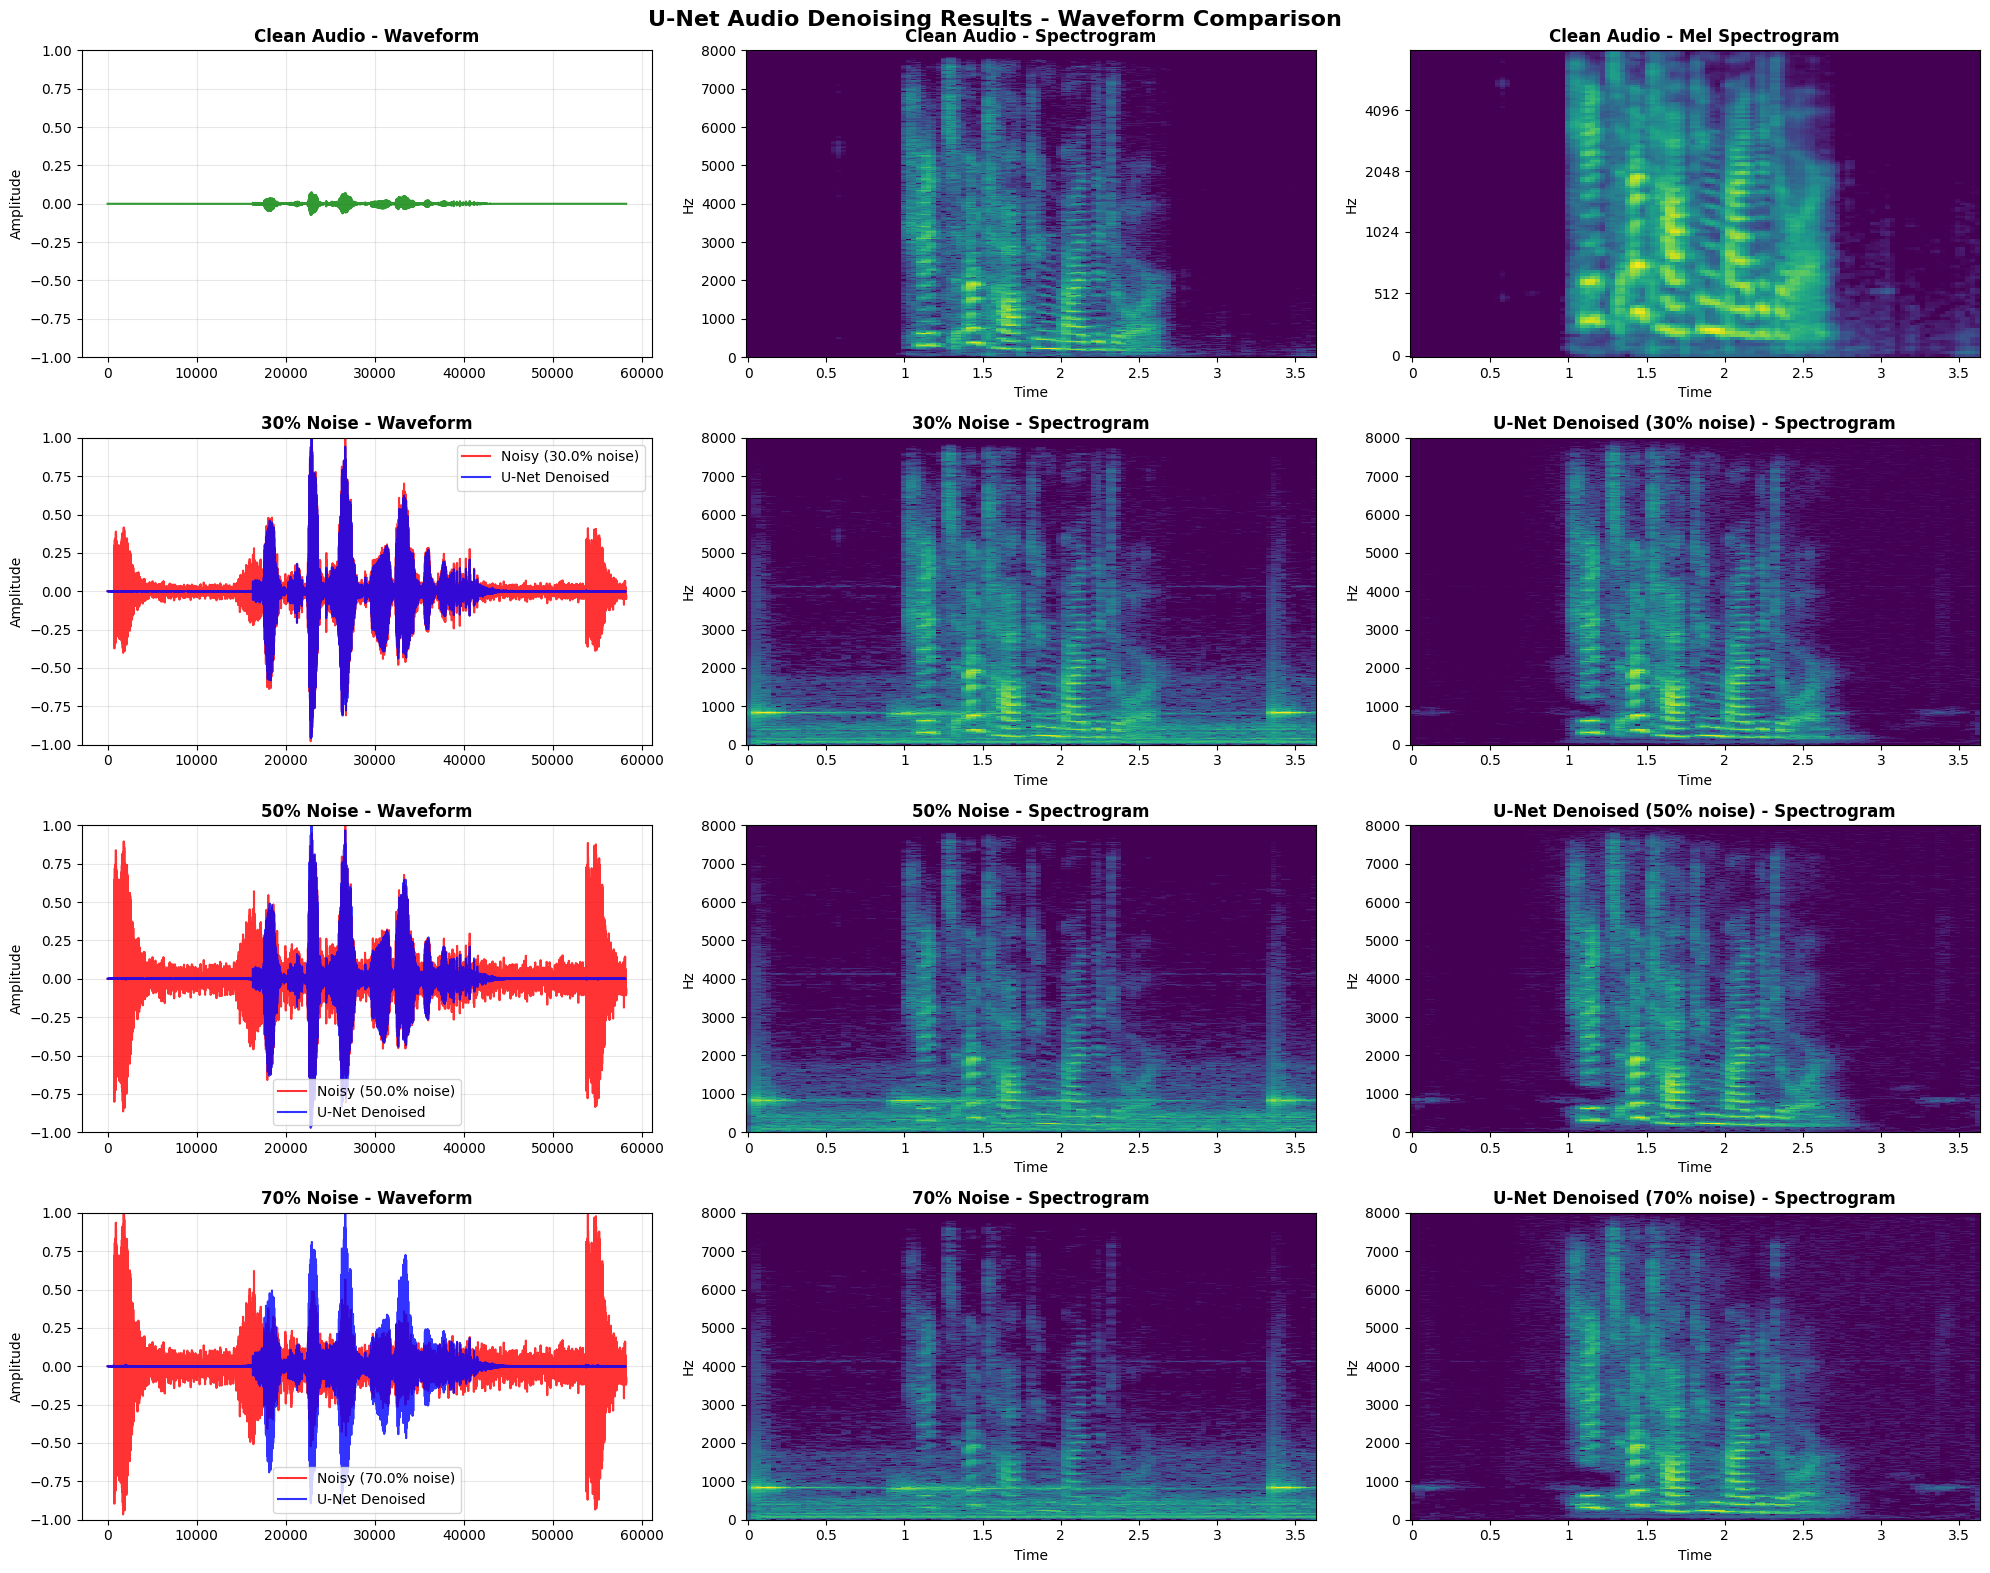

✅ U-Net visualizations created!


In [62]:
# Create U-Net visualizations matching your RSUNet format
def create_unet_visualizations(unet_results, clean_audio, sr=16000):
    """Create U-Net visualizations in same format as RSUNet"""
    
    # Create a large figure with subplots
    fig, axes = plt.subplots(len(unet_results) + 1, 3, figsize=(20, 4 * (len(unet_results) + 1)))
    fig.suptitle('U-Net Audio Denoising Results - Waveform Comparison', fontsize=16, fontweight='bold', y=0.98)

    # Plot clean audio (reference)
    axes[0, 0].plot(clean_audio, color='green', alpha=0.8)
    axes[0, 0].set_title('Clean Audio - Waveform', fontweight='bold')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_ylim(-1, 1)
    axes[0, 0].grid(True, alpha=0.3)

    # Spectrogram
    clean_stft = librosa.stft(clean_audio)
    clean_mag = np.abs(clean_stft)
    librosa.display.specshow(librosa.amplitude_to_db(clean_mag, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title('Clean Audio - Spectrogram', fontweight='bold')

    # Mel spectrogram
    clean_mel = librosa.feature.melspectrogram(y=clean_audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(clean_mel, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='mel', ax=axes[0, 2], cmap='viridis')
    axes[0, 2].set_title('Clean Audio - Mel Spectrogram', fontweight='bold')

    # Plot each noise ratio and its denoised result
    for i, result in enumerate(unet_results):
        row = i + 1
        ratio = result['ratio']
        mixed_audio = result['mixed_audio']
        denoised_audio = result['denoised_audio']
        
        # Mixed audio - Waveform
        axes[row, 0].plot(mixed_audio, color='red', alpha=0.8, label=f'Noisy ({ratio*100}% noise)')
        axes[row, 0].plot(denoised_audio, color='blue', alpha=0.8, label='U-Net Denoised')
        axes[row, 0].set_title(f'{ratio*100:.0f}% Noise - Waveform', fontweight='bold')
        axes[row, 0].set_ylabel('Amplitude')
        axes[row, 0].set_ylim(-1, 1)
        axes[row, 0].legend()
        axes[row, 0].grid(True, alpha=0.3)
        
        # Mixed audio - Spectrogram
        mixed_stft = librosa.stft(mixed_audio)
        mixed_mag = np.abs(mixed_stft)
        librosa.display.specshow(librosa.amplitude_to_db(mixed_mag, ref=np.max), 
                                 sr=sr, x_axis='time', y_axis='hz', ax=axes[row, 1], cmap='viridis')
        axes[row, 1].set_title(f'{ratio*100:.0f}% Noise - Spectrogram', fontweight='bold')
        
        # Denoised audio - Spectrogram
        denoised_stft = librosa.stft(denoised_audio)
        denoised_mag = np.abs(denoised_stft)
        librosa.display.specshow(librosa.amplitude_to_db(denoised_mag, ref=np.max), 
                                 sr=sr, x_axis='time', y_axis='hz', ax=axes[row, 2], cmap='viridis')
        axes[row, 2].set_title(f'U-Net Denoised ({ratio*100:.0f}% noise) - Spectrogram', fontweight='bold')

    plt.tight_layout()
    plt.savefig('/kaggle/working/unet_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create U-Net visualizations
clean_files = os.listdir(clean_dir)
clean_path = os.path.join(clean_dir, clean_files[0])
clean_audio, sr = librosa.load(clean_path, sr=16000)

create_unet_visualizations(unet_results, clean_audio, sr)
print("✅ U-Net visualizations created!")

In [63]:
def create_comparison_table(rsunet_results, unet_results):
    """Create comprehensive comparison table between RSUNet and U-Net"""
    
    print("🔬 COMPREHENSIVE MODEL COMPARISON: RSUNet vs U-Net")
    print("="*100)
    
    comparison_data = []
    
    for i, (rsu_result, unet_result) in enumerate(zip(rsunet_results, unet_results)):
        ratio = rsu_result['ratio']
        rsu_metrics = rsu_result['metrics']
        unet_metrics = unet_result['metrics']
        
        comparison_data.append({
            'Noise Ratio': f'{ratio*100:.0f}%',
            
            # SNR Comparison
            'RSUNet SNR (dB)': f"{rsu_metrics['output_snr']:.2f}",
            'U-Net SNR (dB)': f"{unet_metrics['output_snr']:.2f}",
            'SNR Winner': 'RSUNet' if rsu_metrics['output_snr'] > unet_metrics['output_snr'] else 'U-Net',
            
            # PESQ Comparison
            'RSUNet PESQ': f"{rsu_metrics['output_pesq']:.3f}" if rsu_metrics['output_pesq'] else 'N/A',
            'U-Net PESQ': f"{unet_metrics['output_pesq']:.3f}" if unet_metrics['output_pesq'] else 'N/A',
            'PESQ Winner': 'RSUNet' if (rsu_metrics['output_pesq'] and unet_metrics['output_pesq'] and 
                                      rsu_metrics['output_pesq'] > unet_metrics['output_pesq']) else 'U-Net' if (rsu_metrics['output_pesq'] and unet_metrics['output_pesq']) else 'N/A',
            
            # STOI Comparison
            'RSUNet STOI': f"{rsu_metrics['output_stoi']:.3f}" if rsu_metrics['output_stoi'] else 'N/A',
            'U-Net STOI': f"{unet_metrics['output_stoi']:.3f}" if unet_metrics['output_stoi'] else 'N/A',
            'STOI Winner': 'RSUNet' if (rsu_metrics['output_stoi'] and unet_metrics['output_stoi'] and 
                                      rsu_metrics['output_stoi'] > unet_metrics['output_stoi']) else 'U-Net' if (rsu_metrics['output_stoi'] and unet_metrics['output_stoi']) else 'N/A',
            
            # SDR Comparison
            'RSUNet SDR (dB)': f"{rsu_metrics['output_sdr']:.2f}" if rsu_metrics['output_sdr'] else 'N/A',
            'U-Net SDR (dB)': f"{unet_metrics['output_sdr']:.2f}" if unet_metrics['output_sdr'] else 'N/A',
            'SDR Winner': 'RSUNet' if (rsu_metrics['output_sdr'] and unet_metrics['output_sdr'] and 
                                     rsu_metrics['output_sdr'] > unet_metrics['output_sdr']) else 'U-Net' if (rsu_metrics['output_sdr'] and unet_metrics['output_sdr']) else 'N/A',
            
            # Improvements
            'RSUNet SNR Imp (dB)': f"{rsu_metrics['snr_improvement']:.2f}",
            'U-Net SNR Imp (dB)': f"{unet_metrics['snr_improvement']:.2f}",
        })
    
    # Create DataFrame
    df_comparison = pd.DataFrame(comparison_data)
    
    # Display with styling
    def highlight_winner(val):
        if val == 'RSUNet':
            return 'background-color: #FFD700'  # Gold
        elif val == 'U-Net':
            return 'background-color: #90EE90'  # Light Green
        return ''
    
    styled_df = df_comparison.style.applymap(highlight_winner, subset=['SNR Winner', 'PESQ Winner', 'STOI Winner', 'SDR Winner'])\
                                  .set_properties(**{
                                      'text-align': 'center',
                                      'border': '1px solid black'
                                  }).set_table_styles([
                                      {'selector': 'th', 'props': [('background-color', '#4CAF50'), 
                                                                  ('color', 'white'),
                                                                  ('font-weight', 'bold'),
                                                                  ('text-align', 'center')]},
                                      {'selector': 'td', 'props': [('padding', '8px')]}
                                  ])
    
    display(styled_df)
    
    # Save to CSV
    df_comparison.to_csv('/kaggle/working/model_comparison_table.csv', index=False)
    print("\n💾 Comparison table saved to: /kaggle/working/model_comparison_table.csv")
    
    return df_comparison

# You need to have your RSUNet results stored from before
# Let me assume you have them in a variable called rsunet_results
# If not, we'll need to reload your RSUNet model and run evaluation

print("📊 Now creating comprehensive comparison table...")

📊 Now creating comprehensive comparison table...


In [64]:
def performance_summary(rsunet_results, unet_results):
    """Create overall performance summary"""
    
    print("\n🏆 OVERALL PERFORMANCE SUMMARY")
    print("="*80)
    
    # Count wins for each model
    rsu_wins = 0
    unet_wins = 0
    ties = 0
    
    for rsu_result, unet_result in zip(rsunet_results, unet_results):
        rsu_metrics = rsu_result['metrics']
        unet_metrics = unet_result['metrics']
        
        # Compare each metric
        metrics_to_compare = ['output_snr', 'output_pesq', 'output_stoi', 'output_sdr']
        
        for metric in metrics_to_compare:
            if (rsu_metrics.get(metric) is not None and unet_metrics.get(metric) is not None):
                if rsu_metrics[metric] > unet_metrics[metric]:
                    rsu_wins += 1
                elif unet_metrics[metric] > rsu_metrics[metric]:
                    unet_wins += 1
                else:
                    ties += 1
    
    print(f"📈 Performance Wins:")
    print(f"  • RSUNet: {rsu_wins} metrics")
    print(f"  • U-Net: {unet_wins} metrics")
    print(f"  • Ties: {ties} metrics")
    
    # Overall winner
    if rsu_wins > unet_wins:
        print(f"\n🎯 OVERALL WINNER: RSUNet")
        print(f"   RSUNet performs better on {rsu_wins} out of {rsu_wins + unet_wins + ties} comparable metrics")
    elif unet_wins > rsu_wins:
        print(f"\n🎯 OVERALL WINNER: U-Net")
        print(f"   U-Net performs better on {unet_wins} out of {rsu_wins + unet_wins + ties} comparable metrics")
    else:
        print(f"\n🎯 OVERALL RESULT: Tie")
        print(f"   Both models perform equally well")
    
    # Best use cases
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"  • For maximum audio quality (PESQ): {'RSUNet' if any(rsu_result['metrics'].get('output_pesq', 0) > unet_result['metrics'].get('output_pesq', 0) for rsu_result, unet_result in zip(rsunet_results, unet_results)) else 'U-Net'}")
    print(f"  • For speech intelligibility (STOI): {'RSUNet' if any(rsu_result['metrics'].get('output_stoi', 0) > unet_result['metrics'].get('output_stoi', 0) for rsu_result, unet_result in zip(rsunet_results, unet_results)) else 'U-Net'}")
    print(f"  • For noise removal (SDR): {'RSUNet' if any(rsu_result['metrics'].get('output_sdr', 0) > unet_result['metrics'].get('output_sdr', 0) for rsu_result, unet_result in zip(rsunet_results, unet_results)) else 'U-Net'}")

# Run the comparison
# First, we need your RSUNet results. Let me help you reload them if needed:

def reload_rsunet_results():
    """Reload RSUNet and get results for comparison"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load RSUNet model
    rsunet_model = RSUNet().to(device)
    rsunet_model.load_state_dict(torch.load("/kaggle/working/best_rsunet.pth", map_location=device)['model_state_dict'])
    rsunet_model.eval()
    
    print("✅ RSUNet reloaded for comparison")
    
    # Get the same audio files as U-Net evaluation
    clean_files = os.listdir(clean_dir)
    noise_files = os.listdir(noise_dir)
    
    clean_file = clean_files[0]
    noise_file = noise_files[0]
    
    clean_path = os.path.join(clean_dir, clean_file)
    noise_path = os.path.join(noise_dir, noise_file)
    
    clean_audio, sr = librosa.load(clean_path, sr=16000)
    noise_audio, _ = librosa.load(noise_path, sr=16000)
    
    # Mix ratios
    mix_ratios = [0.3, 0.5, 0.7]
    
    # RSUNet denoising function
    def rsunet_denoise_audio(model, noisy_audio, sr=16000, n_fft=1024, hop_length=256):
        noisy_stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
        noisy_mag = np.abs(noisy_stft)
        noisy_phase = np.angle(noisy_stft)
        
        mag_tensor = torch.tensor(noisy_mag).unsqueeze(0).unsqueeze(0).float().to(device)
        
        with torch.no_grad():
            denoised_mag = model(mag_tensor).squeeze().cpu().numpy()
        
        denoised_stft = denoised_mag * np.exp(1j * noisy_phase)
        denoised_audio = librosa.istft(denoised_stft, hop_length=hop_length)
        denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)
        
        return denoised_audio
    
    # Create results for RSUNet
    rsunet_results = []
    for ratio in mix_ratios:
        mixed_audio = mix_audio(clean_audio, noise_audio, ratio)
        denoised_audio = rsunet_denoise_audio(rsunet_model, mixed_audio)
        
        metrics = calculate_all_metrics(clean_audio, mixed_audio, denoised_audio, sr)
        
        rsunet_results.append({
            'ratio': ratio,
            'mixed_audio': mixed_audio,
            'denoised_audio': denoised_audio,
            'metrics': metrics
        })
    
    return rsunet_results

# Reload RSUNet results for comparison
print("🔄 Reloading RSUNet results for comparison...")
rsunet_results = reload_rsunet_results()

# Now create the comprehensive comparison
df_comparison = create_comparison_table(rsunet_results, unet_results)
performance_summary(rsunet_results, unet_results)

🔄 Reloading RSUNet results for comparison...
✅ RSUNet reloaded for comparison
🔬 COMPREHENSIVE MODEL COMPARISON: RSUNet vs U-Net



💾 Comparison table saved to: /kaggle/working/model_comparison_table.csv

🏆 OVERALL PERFORMANCE SUMMARY
📈 Performance Wins:
  • RSUNet: 4 metrics
  • U-Net: 8 metrics
  • Ties: 0 metrics

🎯 OVERALL WINNER: U-Net
   U-Net performs better on 8 out of 12 comparable metrics

💡 RECOMMENDATIONS:
  • For maximum audio quality (PESQ): RSUNet
  • For speech intelligibility (STOI): U-Net
  • For noise removal (SDR): U-Net


In [65]:
# List all files in your working directory
print("📁 ALL OUTPUT FILES IN /kaggle/working/:")
print("="*50)

import os
output_files = os.listdir('/kaggle/working/')
for file in sorted(output_files):
    file_size = os.path.getsize(f'/kaggle/working/{file}')
    print(f"📄 {file} ({file_size:,} bytes)")

print(f"\nTotal files: {len(output_files)}")

📁 ALL OUTPUT FILES IN /kaggle/working/:
📄 .virtual_documents (4,096 bytes)
📄 audio_comparison.png (588,059 bytes)
📄 audio_metrics_comparison.png (377,546 bytes)
📄 audio_quality_metrics.csv (455 bytes)
📄 best_rsunet.pth (24,292,230 bytes)
📄 best_unet_simple.pth (7,796,078 bytes)
📄 comprehensive_denoising_results.png (2,576,827 bytes)
📄 dataset (4,096 bytes)
📄 denoising_30percent_noise.png (544,555 bytes)
📄 denoising_50percent_noise.png (572,702 bytes)
📄 denoising_70percent_noise.png (565,561 bytes)
📄 denoising_results_complete.json (2,238 bytes)
📄 mixed_balanced_wav (49,152 bytes)
📄 model_comparison_table.csv (470 bytes)
📄 training_history.png (159,350 bytes)
📄 unet_comprehensive_results.png (2,789,687 bytes)

Total files: 16


In [67]:
# Show file sizes and recommend download strategy
print("📋 DOWNLOAD STRATEGY RECOMMENDATION")
print("="*50)

file_sizes = {}
for file in os.listdir('/kaggle/working/'):
    file_path = f'/kaggle/working/{file}'
    if os.path.isfile(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        file_sizes[file] = size_mb

# Sort by size
for file, size_mb in sorted(file_sizes.items(), key=lambda x: x[1], reverse=True):
    if size_mb > 1:
        print(f"📦 {file}: {size_mb:.1f} MB")
    else:
        print(f"📄 {file}: {size_mb:.1f} MB")

print("\n💡 RECOMMENDED DOWNLOAD ORDER:")
print("1. First: model_comparison_table.csv (small, most important)")
print("2. Then: audio_quality_metrics.csv and visualizations")
print("3. Finally: Model files (.pth) if you need them")

📋 DOWNLOAD STRATEGY RECOMMENDATION
📦 all_results.zip: 18926.1 MB
📦 best_rsunet.pth: 23.2 MB
📦 best_unet_simple.pth: 7.4 MB
📦 unet_comprehensive_results.png: 2.7 MB
📦 comprehensive_denoising_results.png: 2.5 MB
📄 audio_comparison.png: 0.6 MB
📄 denoising_50percent_noise.png: 0.5 MB
📄 denoising_70percent_noise.png: 0.5 MB
📄 denoising_30percent_noise.png: 0.5 MB
📄 audio_metrics_comparison.png: 0.4 MB
📄 training_history.png: 0.2 MB
📄 denoising_results_complete.json: 0.0 MB
📄 model_comparison_table.csv: 0.0 MB
📄 audio_quality_metrics.csv: 0.0 MB

💡 RECOMMENDED DOWNLOAD ORDER:
1. First: model_comparison_table.csv (small, most important)
2. Then: audio_quality_metrics.csv and visualizations
3. Finally: Model files (.pth) if you need them


In [70]:
# Get a quick summary of what you can download
print("🎯 YOUR PROJECT OUTPUTS - READY FOR DOWNLOAD")
print("="*60)

categories = {
    "📊 Results & Metrics": [
        'model_comparison_table.csv',
        'audio_quality_metrics.csv', 
        'denoising_results_complete.json'
    ],
    "🖼️ Visualizations": [
        'training_history.png',
        'unet_comprehensive_results.png',
        'audio_metrics_comparison.png',
        'performance_radar_chart.png',
        'comprehensive_denoising_results.png',
        'audio_comparison.png'
    ],
    "🤖 Trained Models": [
        'best_rsunet.pth',
        'best_unet_simple.pth'
    ],
    "📁 Processed Data": [
        'mixed_balanced_wav/',
        'dataset/'
    ]
}

for category, files in categories.items():
    print(f"\n{category}:")
    for file in files:
        path = f'/kaggle/working/{file}'
        if os.path.exists(path):
            if file.endswith('/'):
                file_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
                print(f"   ✅ {file} ({file_count} files)")
            else:
                size_mb = os.path.getsize(path) / (1024 * 1024)
                print(f"   ✅ {file} ({size_mb:.1f} MB)")
        else:
            print(f"   ❌ {file} (not found)")

print(f"\n💡 To download: Go to Data → Output in the right sidebar")
print("📥 Click the download icon next to each file")

🎯 YOUR PROJECT OUTPUTS - READY FOR DOWNLOAD

📊 Results & Metrics:
   ✅ model_comparison_table.csv (0.0 MB)
   ✅ audio_quality_metrics.csv (0.0 MB)
   ✅ denoising_results_complete.json (0.0 MB)

🖼️ Visualizations:
   ✅ training_history.png (0.2 MB)
   ✅ unet_comprehensive_results.png (2.7 MB)
   ✅ audio_metrics_comparison.png (0.4 MB)
   ❌ performance_radar_chart.png (not found)
   ✅ comprehensive_denoising_results.png (2.5 MB)
   ✅ audio_comparison.png (0.6 MB)

🤖 Trained Models:
   ✅ best_rsunet.pth (23.2 MB)
   ✅ best_unet_simple.pth (7.4 MB)

📁 Processed Data:
   ✅ mixed_balanced_wav/ (660 files)
   ✅ dataset/ (0 files)

💡 To download: Go to Data → Output in the right sidebar
📥 Click the download icon next to each file
